<a href="https://colab.research.google.com/github/uahuser00000/shin_final_cpe490590/blob/main/CIFAR_10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model for Image Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import random

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn import svm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torch.utils.data import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Change data path to where cifar-10 data is located in your drive
import sys
import os
data_path = "/content/drive/MyDrive/cpe590/final/data/cifar-10-batches-py/"
os.chdir(data_path)

Mounted at /content/drive


In [3]:
# Class to unpickle the dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# Load class names
meta = unpickle('batches.meta')
class_names = [name.decode('utf-8') for name in meta[b'label_names']]
print("Class names:", class_names)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# Load training data
images_train, labels_train = [], []
for i in range(1, 6):
    batch = unpickle(os.path.join(data_path, f'data_batch_{i}'))
    images_train.append(batch[b'data'])
    labels_train.extend(batch[b'labels'])

images_train = np.concatenate(images_train).reshape(-1, 3, 32, 32).astype('float32') / 255.0
labels_train = np.array(labels_train)
img_to_view_train = images_train

# Load test data
batch_test = unpickle('test_batch')
images_test = batch_test[b'data'].reshape(-1, 3, 32, 32).astype('float32') / 255.0
labels_test = np.array(batch_test[b'labels'])
img_to_view_test = images_test


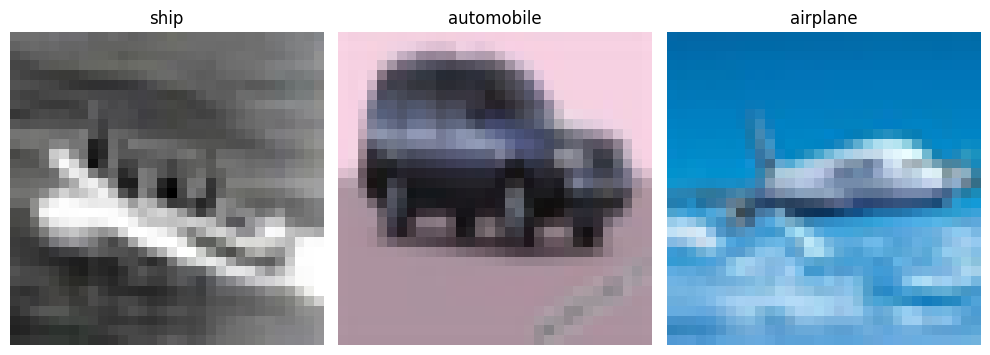

In [6]:
# Show random images and class
num_img = 3
img_t = img_to_view_train.shape[0]
random_indices = random.sample(range(img_t), num_img)

plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
    plt.subplot(1, num_img, i + 1)
    img = img_to_view_train[index].transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(class_names[labels_train[index]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# channel-wise standardization
mean = np.array([0.4914, 0.4822, 0.4465]).reshape(1, 3, 1, 1)
std = np.array([0.2023, 0.1994, 0.2010]).reshape(1, 3, 1, 1)

images_train = (images_train - mean) / std
images_test = (images_test - mean) / std

In [8]:
# CUDA check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
# Datasets
x_train_np = images_train
y_train_np = labels_train
x_test = torch.tensor(images_test, dtype=torch.float32)
y_test = torch.tensor(labels_test, dtype=torch.long)
x_train_np.shape , x_test.shape , y_train_np.shape , y_test.shape

((50000, 3, 32, 32),
 torch.Size([10000, 3, 32, 32]),
 (50000,),
 torch.Size([10000]))

In [10]:
# Splitting of training to make the validation dataset
validation_fraction = 0.2
random_seed = 42

x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(
    x_train_np, y_train_np, test_size=validation_fraction, random_state=random_seed, stratify=y_train_np
)

# Convert the split NumPy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train_split, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_split, dtype=torch.long)
x_valid_tensor = torch.tensor(x_valid_split, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_split, dtype=torch.long)

In [11]:
# Create DataLoader
batch_size = 100

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size * 2, shuffle=False)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False)

In [12]:
# CNN model from the paper "Classification of Image with Convolutional Neural Network and TensorFlow on CIFAR-10 Dataset" by Gunjan Sharma and Vijay K. Jadon

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(1152, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
model = CNNNet().to(device)
print(model)

CNNNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [14]:
from tqdm import tqdm
def train_and_evaluate(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = CNNNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Track metrics
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    test_accuracy = None

    epochs = 25
    best_valid_loss = float('inf')
    best_model_wts = None

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

        train_losses.append(train_loss / total)
        train_accuracies.append(correct / total)

        model.eval()
        valid_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

        val_loss_epoch = valid_loss / total_val
        valid_losses.append(val_loss_epoch)
        valid_accuracies.append(correct_val / total_val)

        if val_loss_epoch < best_valid_loss:
            best_valid_loss = val_loss_epoch
            best_model_wts = model.state_dict()

        print(f"Epoch {epoch:2d}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")

    # Load best model
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # Final Test Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    all_test_images = []
    correct_test = 0
    total_test = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_test_images.extend(inputs.cpu().numpy())
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    torch.cuda.empty_cache()
    return test_accuracy, train_losses, valid_losses, train_accuracies, valid_accuracies, all_test_images, all_preds, all_labels

In [15]:
import scipy.stats as st

# Training the model 5 times
run_train_accuracies = []
run_valid_accuracies = []
run_test_accuracies = []

for i in range(5):
    print(f"Running seed {i}")
    test_acc, train_losses, valid_losses, train_acc, valid_acc, all_test_images, all_preds, all_labels = train_and_evaluate(seed=i)

    run_train_accuracies.append(np.mean(train_acc))  # Mean training accuracy across epochs
    run_valid_accuracies.append(np.mean(valid_acc))  # Mean validation accuracy across epochs
    run_test_accuracies.append(test_acc)             # Final test accuracy

def compute_confidence_interval(data, alpha=0.05):
    data = np.array(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    n = len(data)
    t_critical = st.t.ppf(1 - alpha/2, df=n-1)
    half_width = t_critical * std / np.sqrt(n)
    return mean, mean - half_width, mean + half_width

# Training accuracy
mean_train_acc, ci_lower_train, ci_upper_train = compute_confidence_interval(run_train_accuracies)
print(f"\nMean Training Accuracy: {mean_train_acc:.4f}")
print(f"95% Confidence Interval (Training): ({ci_lower_train:.4f}, {ci_upper_train:.4f})")

# Validation accuracy
mean_valid_acc, ci_lower_valid, ci_upper_valid = compute_confidence_interval(run_valid_accuracies)
print(f"\nMean Validation Accuracy: {mean_valid_acc:.4f}")
print(f"95% Confidence Interval (Validation): ({ci_lower_valid:.4f}, {ci_upper_valid:.4f})")

# Test accuracy
mean_test_acc, ci_lower_test, ci_upper_test = compute_confidence_interval(run_test_accuracies)
print(f"\nMean Test Accuracy: {mean_test_acc:.4f}")
print(f"95% Confidence Interval (Test): ({ci_lower_test:.4f}, {ci_upper_test:.4f})")

Running seed 0


  4%|▍         | 1/25 [01:00<24:14, 60.61s/it]

Epoch  1, Train Loss: 1.7438, Valid Loss: 1.4721


  8%|▊         | 2/25 [01:57<22:23, 58.41s/it]

Epoch  2, Train Loss: 1.3582, Valid Loss: 1.2776


 12%|█▏        | 3/25 [02:57<21:45, 59.34s/it]

Epoch  3, Train Loss: 1.2018, Valid Loss: 1.1605


 16%|█▌        | 4/25 [03:48<19:36, 56.02s/it]

Epoch  4, Train Loss: 1.1053, Valid Loss: 1.0977


 20%|██        | 5/25 [04:35<17:33, 52.69s/it]

Epoch  5, Train Loss: 1.0410, Valid Loss: 1.0608


 24%|██▍       | 6/25 [05:21<15:54, 50.25s/it]

Epoch  6, Train Loss: 0.9930, Valid Loss: 1.0421


 28%|██▊       | 7/25 [06:07<14:39, 48.85s/it]

Epoch  7, Train Loss: 0.9535, Valid Loss: 0.9986


 32%|███▏      | 8/25 [06:54<13:40, 48.24s/it]

Epoch  8, Train Loss: 0.9185, Valid Loss: 1.0028


 36%|███▌      | 9/25 [07:39<12:35, 47.23s/it]

Epoch  9, Train Loss: 0.8899, Valid Loss: 0.9705


 40%|████      | 10/25 [08:24<11:38, 46.57s/it]

Epoch 10, Train Loss: 0.8591, Valid Loss: 0.9485


 44%|████▍     | 11/25 [09:08<10:44, 46.03s/it]

Epoch 11, Train Loss: 0.8405, Valid Loss: 0.9397


 48%|████▊     | 12/25 [09:54<09:56, 45.91s/it]

Epoch 12, Train Loss: 0.8178, Valid Loss: 0.9326


 52%|█████▏    | 13/25 [10:40<09:10, 45.91s/it]

Epoch 13, Train Loss: 0.7962, Valid Loss: 0.8920


 56%|█████▌    | 14/25 [11:26<08:25, 45.94s/it]

Epoch 14, Train Loss: 0.7798, Valid Loss: 0.9163


 60%|██████    | 15/25 [12:11<07:36, 45.66s/it]

Epoch 15, Train Loss: 0.7630, Valid Loss: 0.8911


 64%|██████▍   | 16/25 [12:58<06:55, 46.15s/it]

Epoch 16, Train Loss: 0.7445, Valid Loss: 0.9303


 68%|██████▊   | 17/25 [13:44<06:09, 46.14s/it]

Epoch 17, Train Loss: 0.7307, Valid Loss: 0.9157


 72%|███████▏  | 18/25 [14:29<05:19, 45.71s/it]

Epoch 18, Train Loss: 0.7147, Valid Loss: 0.9126


 76%|███████▌  | 19/25 [15:14<04:32, 45.40s/it]

Epoch 19, Train Loss: 0.6977, Valid Loss: 0.8715


 80%|████████  | 20/25 [16:00<03:47, 45.50s/it]

Epoch 20, Train Loss: 0.6859, Valid Loss: 0.8673


 84%|████████▍ | 21/25 [16:44<03:01, 45.32s/it]

Epoch 21, Train Loss: 0.6679, Valid Loss: 0.8638


 88%|████████▊ | 22/25 [17:31<02:17, 45.68s/it]

Epoch 22, Train Loss: 0.6550, Valid Loss: 0.8542


 92%|█████████▏| 23/25 [18:16<01:30, 45.41s/it]

Epoch 23, Train Loss: 0.6396, Valid Loss: 0.9055


 96%|█████████▌| 24/25 [19:02<00:45, 45.55s/it]

Epoch 24, Train Loss: 0.6304, Valid Loss: 0.8725


100%|██████████| 25/25 [19:47<00:00, 47.49s/it]

Epoch 25, Train Loss: 0.6156, Valid Loss: 0.9130


Running seed 1


  4%|▍         | 1/25 [00:46<18:29, 46.22s/it]

Epoch  1, Train Loss: 1.7644, Valid Loss: 1.4769


  8%|▊         | 2/25 [01:32<17:49, 46.51s/it]

Epoch  2, Train Loss: 1.3598, Valid Loss: 1.3075


 12%|█▏        | 3/25 [02:19<17:01, 46.42s/it]

Epoch  3, Train Loss: 1.2232, Valid Loss: 1.1814


 16%|█▌        | 4/25 [03:05<16:14, 46.38s/it]

Epoch  4, Train Loss: 1.1289, Valid Loss: 1.1213


 20%|██        | 5/25 [03:52<15:34, 46.71s/it]

Epoch  5, Train Loss: 1.0598, Valid Loss: 1.0573


 24%|██▍       | 6/25 [04:39<14:44, 46.55s/it]

Epoch  6, Train Loss: 1.0059, Valid Loss: 1.0492


 28%|██▊       | 7/25 [05:25<13:58, 46.59s/it]

Epoch  7, Train Loss: 0.9685, Valid Loss: 1.0198


 32%|███▏      | 8/25 [06:13<13:20, 47.08s/it]

Epoch  8, Train Loss: 0.9332, Valid Loss: 1.0007


 36%|███▌      | 9/25 [07:00<12:29, 46.82s/it]

Epoch  9, Train Loss: 0.9046, Valid Loss: 0.9835


 40%|████      | 10/25 [07:47<11:46, 47.08s/it]

Epoch 10, Train Loss: 0.8785, Valid Loss: 0.9727


 44%|████▍     | 11/25 [08:34<10:56, 46.92s/it]

Epoch 11, Train Loss: 0.8536, Valid Loss: 0.9471


 48%|████▊     | 12/25 [09:20<10:07, 46.75s/it]

Epoch 12, Train Loss: 0.8333, Valid Loss: 0.9607


 52%|█████▏    | 13/25 [10:08<09:22, 46.91s/it]

Epoch 13, Train Loss: 0.8124, Valid Loss: 0.9842


 56%|█████▌    | 14/25 [10:54<08:34, 46.78s/it]

Epoch 14, Train Loss: 0.7928, Valid Loss: 0.9208


 60%|██████    | 15/25 [11:41<07:47, 46.77s/it]

Epoch 15, Train Loss: 0.7739, Valid Loss: 0.9292


 64%|██████▍   | 16/25 [12:28<07:02, 46.98s/it]

Epoch 16, Train Loss: 0.7616, Valid Loss: 0.8914


 68%|██████▊   | 17/25 [13:15<06:15, 46.99s/it]

Epoch 17, Train Loss: 0.7412, Valid Loss: 0.8918


 72%|███████▏  | 18/25 [14:02<05:28, 46.97s/it]

Epoch 18, Train Loss: 0.7247, Valid Loss: 0.9199


 76%|███████▌  | 19/25 [14:50<04:44, 47.35s/it]

Epoch 19, Train Loss: 0.7150, Valid Loss: 0.9132


 80%|████████  | 20/25 [15:37<03:55, 47.11s/it]

Epoch 20, Train Loss: 0.6950, Valid Loss: 0.9106


 84%|████████▍ | 21/25 [16:24<03:08, 47.15s/it]

Epoch 21, Train Loss: 0.6802, Valid Loss: 0.9283


 88%|████████▊ | 22/25 [17:12<02:21, 47.31s/it]

Epoch 22, Train Loss: 0.6699, Valid Loss: 0.9042


 92%|█████████▏| 23/25 [17:58<01:34, 47.08s/it]

Epoch 23, Train Loss: 0.6575, Valid Loss: 0.9454


 96%|█████████▌| 24/25 [18:45<00:47, 47.05s/it]

Epoch 24, Train Loss: 0.6428, Valid Loss: 0.9009


100%|██████████| 25/25 [19:32<00:00, 46.91s/it]

Epoch 25, Train Loss: 0.6316, Valid Loss: 0.8851


Running seed 2


  4%|▍         | 1/25 [00:45<18:15, 45.65s/it]

Epoch  1, Train Loss: 1.7556, Valid Loss: 1.4286


  8%|▊         | 2/25 [01:31<17:37, 45.99s/it]

Epoch  2, Train Loss: 1.3211, Valid Loss: 1.2366


 12%|█▏        | 3/25 [02:17<16:45, 45.71s/it]

Epoch  3, Train Loss: 1.1637, Valid Loss: 1.1519


 16%|█▌        | 4/25 [03:02<15:56, 45.55s/it]

Epoch  4, Train Loss: 1.0734, Valid Loss: 1.0878


 20%|██        | 5/25 [03:48<15:13, 45.66s/it]

Epoch  5, Train Loss: 1.0179, Valid Loss: 1.0407


 24%|██▍       | 6/25 [04:34<14:29, 45.79s/it]

Epoch  6, Train Loss: 0.9682, Valid Loss: 1.0340


 28%|██▊       | 7/25 [05:19<13:40, 45.60s/it]

Epoch  7, Train Loss: 0.9312, Valid Loss: 0.9689


 32%|███▏      | 8/25 [06:05<12:54, 45.58s/it]

Epoch  8, Train Loss: 0.8970, Valid Loss: 0.9955


 36%|███▌      | 9/25 [06:51<12:10, 45.66s/it]

Epoch  9, Train Loss: 0.8729, Valid Loss: 0.9487


 40%|████      | 10/25 [07:37<11:26, 45.75s/it]

Epoch 10, Train Loss: 0.8474, Valid Loss: 0.9550


 44%|████▍     | 11/25 [08:22<10:39, 45.67s/it]

Epoch 11, Train Loss: 0.8202, Valid Loss: 0.9515


 48%|████▊     | 12/25 [09:08<09:53, 45.65s/it]

Epoch 12, Train Loss: 0.8039, Valid Loss: 0.9089


 52%|█████▏    | 13/25 [09:54<09:09, 45.79s/it]

Epoch 13, Train Loss: 0.7814, Valid Loss: 0.9450


 56%|█████▌    | 14/25 [10:40<08:23, 45.81s/it]

Epoch 14, Train Loss: 0.7611, Valid Loss: 0.9000


 60%|██████    | 15/25 [11:25<07:36, 45.68s/it]

Epoch 15, Train Loss: 0.7503, Valid Loss: 0.9363


 64%|██████▍   | 16/25 [12:10<06:50, 45.60s/it]

Epoch 16, Train Loss: 0.7321, Valid Loss: 0.8982


 68%|██████▊   | 17/25 [12:57<06:06, 45.77s/it]

Epoch 17, Train Loss: 0.7151, Valid Loss: 0.8754


 72%|███████▏  | 18/25 [13:42<05:20, 45.75s/it]

Epoch 18, Train Loss: 0.7042, Valid Loss: 0.8960


 76%|███████▌  | 19/25 [14:27<04:33, 45.60s/it]

Epoch 19, Train Loss: 0.6871, Valid Loss: 0.9303


 80%|████████  | 20/25 [15:13<03:47, 45.49s/it]

Epoch 20, Train Loss: 0.6775, Valid Loss: 0.9013


 84%|████████▍ | 21/25 [15:59<03:02, 45.73s/it]

Epoch 21, Train Loss: 0.6641, Valid Loss: 0.8780


 88%|████████▊ | 22/25 [16:45<02:17, 45.75s/it]

Epoch 22, Train Loss: 0.6475, Valid Loss: 0.8931


 92%|█████████▏| 23/25 [17:30<01:31, 45.62s/it]

Epoch 23, Train Loss: 0.6354, Valid Loss: 0.8778


 96%|█████████▌| 24/25 [18:15<00:45, 45.52s/it]

Epoch 24, Train Loss: 0.6259, Valid Loss: 0.8683


100%|██████████| 25/25 [19:02<00:00, 45.69s/it]

Epoch 25, Train Loss: 0.6120, Valid Loss: 0.8776


Running seed 3


  4%|▍         | 1/25 [00:45<18:08, 45.36s/it]

Epoch  1, Train Loss: 1.7812, Valid Loss: 1.4760


  8%|▊         | 2/25 [01:31<17:31, 45.71s/it]

Epoch  2, Train Loss: 1.3636, Valid Loss: 1.2754


 12%|█▏        | 3/25 [02:17<16:54, 46.11s/it]

Epoch  3, Train Loss: 1.1939, Valid Loss: 1.1543


 16%|█▌        | 4/25 [03:03<16:03, 45.89s/it]

Epoch  4, Train Loss: 1.0937, Valid Loss: 1.0827


 20%|██        | 5/25 [03:48<15:14, 45.72s/it]

Epoch  5, Train Loss: 1.0315, Valid Loss: 1.0422


 24%|██▍       | 6/25 [04:34<14:30, 45.82s/it]

Epoch  6, Train Loss: 0.9826, Valid Loss: 1.0214


 28%|██▊       | 7/25 [05:20<13:45, 45.88s/it]

Epoch  7, Train Loss: 0.9505, Valid Loss: 1.0792


 32%|███▏      | 8/25 [06:06<12:57, 45.73s/it]

Epoch  8, Train Loss: 0.9173, Valid Loss: 1.0002


 36%|███▌      | 9/25 [06:51<12:09, 45.56s/it]

Epoch  9, Train Loss: 0.8894, Valid Loss: 0.9596


 40%|████      | 10/25 [07:37<11:24, 45.65s/it]

Epoch 10, Train Loss: 0.8662, Valid Loss: 0.9488


 44%|████▍     | 11/25 [08:23<10:39, 45.71s/it]

Epoch 11, Train Loss: 0.8465, Valid Loss: 0.9897


 48%|████▊     | 12/25 [09:08<09:51, 45.52s/it]

Epoch 12, Train Loss: 0.8278, Valid Loss: 0.9537


 52%|█████▏    | 13/25 [09:53<09:05, 45.45s/it]

Epoch 13, Train Loss: 0.8049, Valid Loss: 0.9145


 56%|█████▌    | 14/25 [10:39<08:21, 45.59s/it]

Epoch 14, Train Loss: 0.7864, Valid Loss: 0.9127


 60%|██████    | 15/25 [11:25<07:36, 45.66s/it]

Epoch 15, Train Loss: 0.7682, Valid Loss: 0.9193


 64%|██████▍   | 16/25 [12:10<06:49, 45.53s/it]

Epoch 16, Train Loss: 0.7515, Valid Loss: 0.9159


 68%|██████▊   | 17/25 [12:55<06:03, 45.45s/it]

Epoch 17, Train Loss: 0.7344, Valid Loss: 0.9032


 72%|███████▏  | 18/25 [13:41<05:19, 45.66s/it]

Epoch 18, Train Loss: 0.7232, Valid Loss: 0.9644


 76%|███████▌  | 19/25 [14:27<04:34, 45.73s/it]

Epoch 19, Train Loss: 0.7069, Valid Loss: 0.9562


 80%|████████  | 20/25 [15:13<03:47, 45.59s/it]

Epoch 20, Train Loss: 0.6944, Valid Loss: 0.8977


 84%|████████▍ | 21/25 [15:58<03:01, 45.44s/it]

Epoch 21, Train Loss: 0.6838, Valid Loss: 0.9253


 88%|████████▊ | 22/25 [16:44<02:16, 45.57s/it]

Epoch 22, Train Loss: 0.6645, Valid Loss: 0.9086


 92%|█████████▏| 23/25 [17:29<01:31, 45.68s/it]

Epoch 23, Train Loss: 0.6501, Valid Loss: 0.9460


 96%|█████████▌| 24/25 [18:15<00:45, 45.52s/it]

Epoch 24, Train Loss: 0.6395, Valid Loss: 0.9138


100%|██████████| 25/25 [19:00<00:00, 45.61s/it]

Epoch 25, Train Loss: 0.6291, Valid Loss: 0.9062


Running seed 4


  4%|▍         | 1/25 [00:45<18:04, 45.20s/it]

Epoch  1, Train Loss: 1.7617, Valid Loss: 1.4526


  8%|▊         | 2/25 [01:29<17:12, 44.90s/it]

Epoch  2, Train Loss: 1.3401, Valid Loss: 1.2390


 12%|█▏        | 3/25 [02:14<16:24, 44.76s/it]

Epoch  3, Train Loss: 1.1819, Valid Loss: 1.1561


 16%|█▌        | 4/25 [02:59<15:40, 44.76s/it]

Epoch  4, Train Loss: 1.0885, Valid Loss: 1.1047


 20%|██        | 5/25 [03:45<15:03, 45.17s/it]

Epoch  5, Train Loss: 1.0290, Valid Loss: 1.0393


 24%|██▍       | 6/25 [04:29<14:16, 45.05s/it]

Epoch  6, Train Loss: 0.9819, Valid Loss: 1.0244


 28%|██▊       | 7/25 [05:14<13:29, 44.95s/it]

Epoch  7, Train Loss: 0.9496, Valid Loss: 0.9961


 32%|███▏      | 8/25 [05:59<12:42, 44.88s/it]

Epoch  8, Train Loss: 0.9120, Valid Loss: 0.9858


 36%|███▌      | 9/25 [06:44<11:58, 44.91s/it]

Epoch  9, Train Loss: 0.8883, Valid Loss: 0.9601


 40%|████      | 10/25 [07:30<11:18, 45.22s/it]

Epoch 10, Train Loss: 0.8594, Valid Loss: 0.9795


 44%|████▍     | 11/25 [08:15<10:30, 45.06s/it]

Epoch 11, Train Loss: 0.8378, Valid Loss: 0.9264


 48%|████▊     | 12/25 [08:59<09:44, 44.98s/it]

Epoch 12, Train Loss: 0.8154, Valid Loss: 0.9333


 52%|█████▏    | 13/25 [09:44<08:58, 44.88s/it]

Epoch 13, Train Loss: 0.8010, Valid Loss: 0.9361


 56%|█████▌    | 14/25 [10:29<08:14, 45.00s/it]

Epoch 14, Train Loss: 0.7753, Valid Loss: 0.9192


 60%|██████    | 15/25 [11:15<07:31, 45.15s/it]

Epoch 15, Train Loss: 0.7616, Valid Loss: 0.9246


 64%|██████▍   | 16/25 [12:00<06:45, 45.06s/it]

Epoch 16, Train Loss: 0.7466, Valid Loss: 0.9385


 68%|██████▊   | 17/25 [12:45<06:00, 45.02s/it]

Epoch 17, Train Loss: 0.7247, Valid Loss: 0.8875


 72%|███████▏  | 18/25 [13:30<05:15, 45.08s/it]

Epoch 18, Train Loss: 0.7098, Valid Loss: 0.8743


 76%|███████▌  | 19/25 [14:16<04:32, 45.41s/it]

Epoch 19, Train Loss: 0.6965, Valid Loss: 0.8941


 80%|████████  | 20/25 [15:01<03:46, 45.20s/it]

Epoch 20, Train Loss: 0.6802, Valid Loss: 0.9330


 84%|████████▍ | 21/25 [15:45<03:00, 45.09s/it]

Epoch 21, Train Loss: 0.6678, Valid Loss: 0.9473


 88%|████████▊ | 22/25 [16:30<02:15, 45.03s/it]

Epoch 22, Train Loss: 0.6498, Valid Loss: 0.9017


 92%|█████████▏| 23/25 [17:15<01:30, 45.04s/it]

Epoch 23, Train Loss: 0.6383, Valid Loss: 0.8774


 96%|█████████▌| 24/25 [18:01<00:45, 45.30s/it]

Epoch 24, Train Loss: 0.6247, Valid Loss: 0.8904


100%|██████████| 25/25 [18:46<00:00, 45.07s/it]

Epoch 25, Train Loss: 0.6161, Valid Loss: 0.8858



Mean Training Accuracy: 0.6964
95% Confidence Interval (Training): (0.6904, 0.7024)

Mean Validation Accuracy: 0.6606
95% Confidence Interval (Validation): (0.6552, 0.6661)

Mean Test Accuracy: 0.7018
95% Confidence Interval (Test): (0.6929, 0.7108)


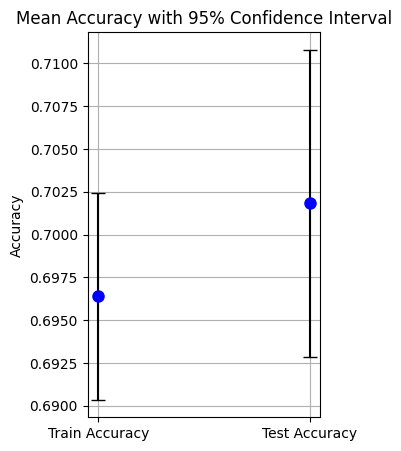

In [16]:
means = [mean_train_acc, mean_test_acc]
lower_errors = [mean_train_acc - ci_lower_train, mean_test_acc - ci_lower_test]
upper_errors = [ci_upper_train - mean_train_acc, ci_upper_test - mean_test_acc]

# Make the error symmetric
error = np.array([lower_errors, upper_errors])

x = np.arange(len(means))  # 0 for train, 1 for test

plt.figure(figsize=(3, 5))
plt.errorbar(x, means, yerr=error, fmt='o', capsize=5, markersize=8, color='blue', ecolor='black', linestyle='none')
plt.xticks(x, ['Train Accuracy', 'Test Accuracy'])
plt.ylabel('Accuracy')
plt.title('Mean Accuracy with 95% Confidence Interval')
plt.grid(True)
plt.show()

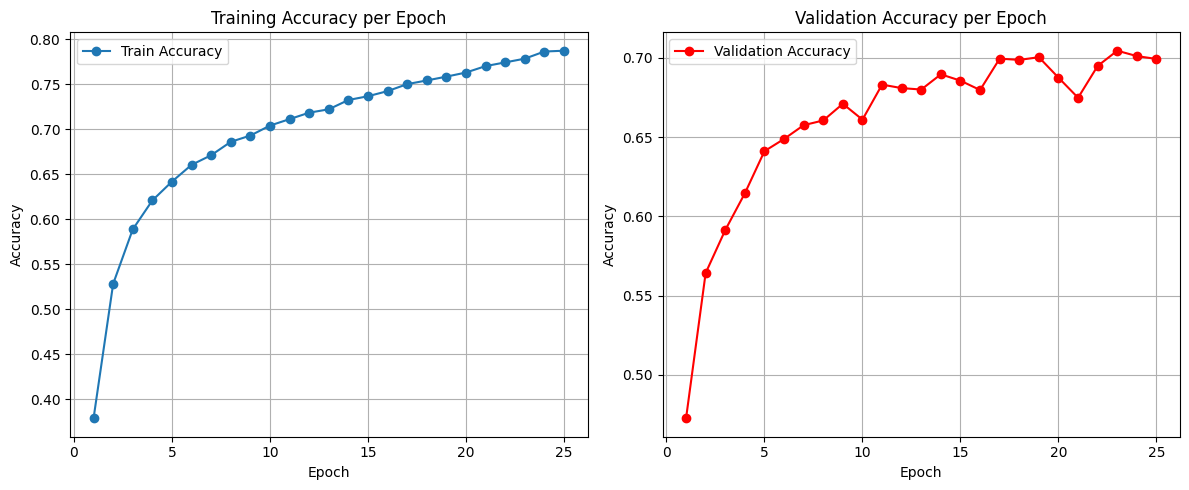

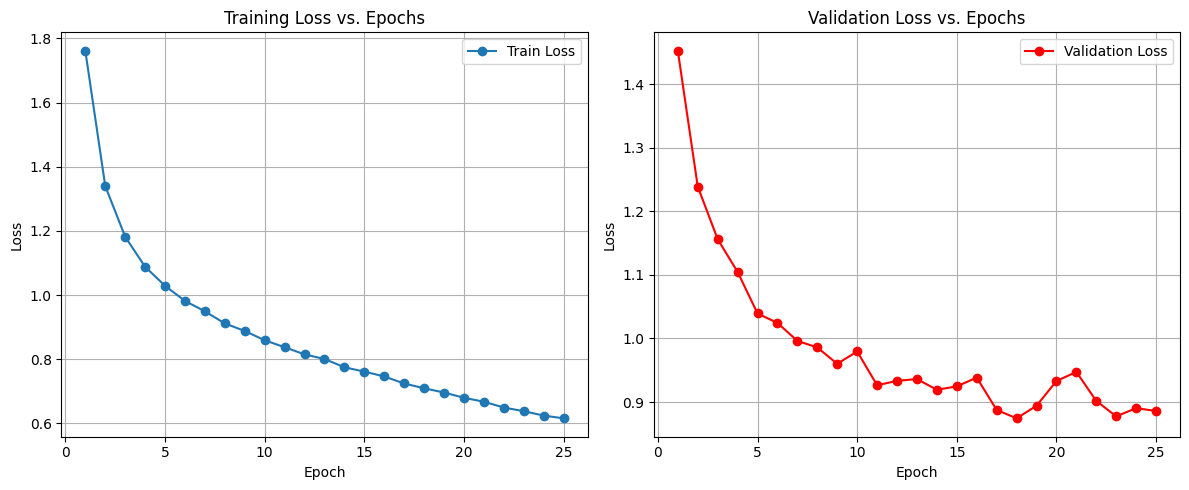

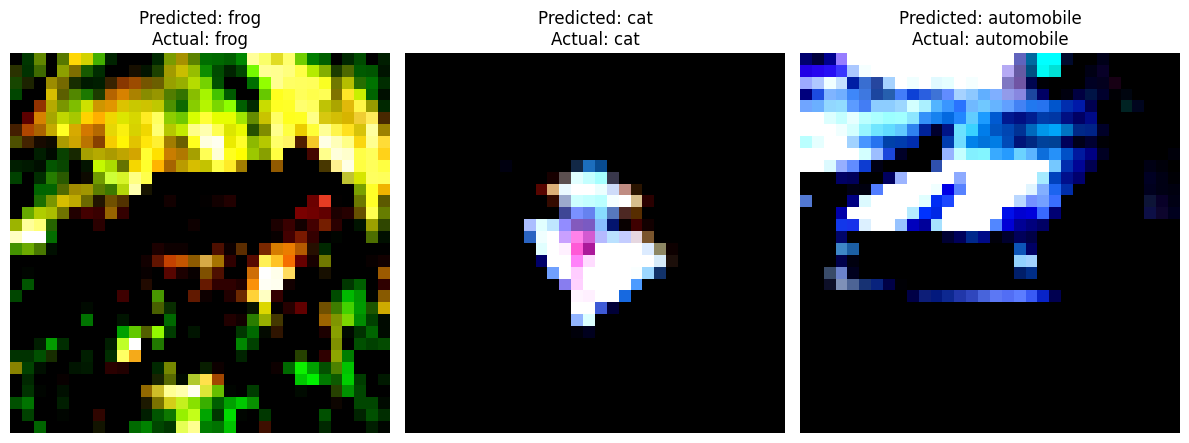

Accuracy: 0.7068
F1 Score (weighted): 0.7061268511963279

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73      1000
           1       0.73      0.90      0.81      1000
           2       0.54      0.69      0.61      1000
           3       0.57      0.50      0.53      1000
           4       0.71      0.59      0.65      1000
           5       0.64      0.62      0.63      1000
           6       0.85      0.69      0.76      1000
           7       0.75      0.77      0.76      1000
           8       0.80      0.81      0.81      1000
           9       0.80      0.76      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



In [17]:
epochs_list = np.arange(1, len(train_acc) + 1)

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_acc, label='Train Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, valid_acc, label='Validation Accuracy', marker='o',color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, valid_losses, label='Validation Loss', marker='o', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

num_img_to_show = min(3, len(all_test_images))
fig = plt.figure(figsize=(12, 6))
for i in range(num_img_to_show):
    random_index = random.randint(0, len(all_test_images) - 1)
    ax = fig.add_subplot(1, num_img_to_show, i + 1)
    ax.axis('off')
    img = all_test_images[random_index].transpose((1, 2, 0))
    ax.imshow(img)
    ax.set_title(f'Predicted: {class_names[all_preds[random_index]]}\nActual: {class_names[all_labels[random_index]]}')
plt.tight_layout()
plt.show()

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("F1 Score (weighted):", f1_score(all_labels, all_preds, average='weighted'))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

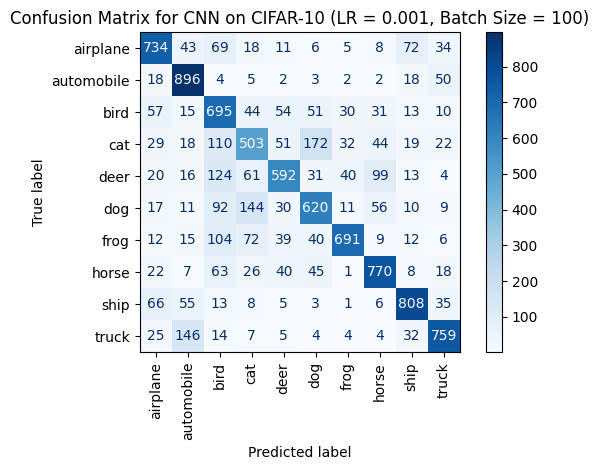

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix for CNN on CIFAR-10 (LR = 0.001, Batch Size = 100)')
plt.tight_layout()
plt.show()

# LR = 1E-04

In [19]:
from tqdm import tqdm
def train_and_evaluate(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = CNNNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Track metrics
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    test_accuracy = None

    epochs = 25
    best_valid_loss = float('inf')
    best_model_wts = None

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

        train_losses.append(train_loss / total)
        train_accuracies.append(correct / total)

        model.eval()
        valid_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

        val_loss_epoch = valid_loss / total_val
        valid_losses.append(val_loss_epoch)
        valid_accuracies.append(correct_val / total_val)

        if val_loss_epoch < best_valid_loss:
            best_valid_loss = val_loss_epoch
            best_model_wts = model.state_dict()

        print(f"Epoch {epoch:2d}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")

    # Load best model
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # Final Test Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    all_test_images = []
    correct_test = 0
    total_test = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_test_images.extend(inputs.cpu().numpy())
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    torch.cuda.empty_cache()
    return test_accuracy, train_losses, valid_losses, train_accuracies, valid_accuracies, all_test_images, all_preds, all_labels

In [21]:
import scipy.stats as st

# Training the model 5 times
run_train_accuracies = []
run_valid_accuracies = []
run_test_accuracies = []

for i in range(5):
    print(f"Running seed {i}")
    test_acc, train_losses, valid_losses, train_acc, valid_acc, all_test_images, all_preds, all_labels = train_and_evaluate(seed=i)

    run_train_accuracies.append(np.mean(train_acc))  # Mean training accuracy across epochs
    run_valid_accuracies.append(np.mean(valid_acc))  # Mean validation accuracy across epochs
    run_test_accuracies.append(test_acc)             # Final test accuracy

def compute_confidence_interval(data, alpha=0.05):
    data = np.array(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    n = len(data)
    t_critical = st.t.ppf(1 - alpha/2, df=n-1)
    half_width = t_critical * std / np.sqrt(n)
    return mean, mean - half_width, mean + half_width

# Training accuracy
mean_train_acc, ci_lower_train, ci_upper_train = compute_confidence_interval(run_train_accuracies)
print(f"\nMean Training Accuracy: {mean_train_acc:.4f}")
print(f"95% Confidence Interval (Training): ({ci_lower_train:.4f}, {ci_upper_train:.4f})")

# Validation accuracy
mean_valid_acc, ci_lower_valid, ci_upper_valid = compute_confidence_interval(run_valid_accuracies)
print(f"\nMean Validation Accuracy: {mean_valid_acc:.4f}")
print(f"95% Confidence Interval (Validation): ({ci_lower_valid:.4f}, {ci_upper_valid:.4f})")

# Test accuracy
mean_test_acc, ci_lower_test, ci_upper_test = compute_confidence_interval(run_test_accuracies)
print(f"\nMean Test Accuracy: {mean_test_acc:.4f}")
print(f"95% Confidence Interval (Test): ({ci_lower_test:.4f}, {ci_upper_test:.4f})")

Running seed 0


  4%|▍         | 1/25 [00:45<18:02, 45.12s/it]

Epoch  1, Train Loss: 2.2030, Valid Loss: 2.0937


  8%|▊         | 2/25 [01:30<17:23, 45.36s/it]

Epoch  2, Train Loss: 1.9959, Valid Loss: 1.9155


 12%|█▏        | 3/25 [02:17<16:52, 46.02s/it]

Epoch  3, Train Loss: 1.8435, Valid Loss: 1.7886


 16%|█▌        | 4/25 [03:03<16:08, 46.10s/it]

Epoch  4, Train Loss: 1.7340, Valid Loss: 1.6935


 20%|██        | 5/25 [03:48<15:15, 45.78s/it]

Epoch  5, Train Loss: 1.6542, Valid Loss: 1.6301


 24%|██▍       | 6/25 [04:34<14:27, 45.67s/it]

Epoch  6, Train Loss: 1.5914, Valid Loss: 1.5723


 28%|██▊       | 7/25 [05:19<13:38, 45.49s/it]

Epoch  7, Train Loss: 1.5427, Valid Loss: 1.5289


 32%|███▏      | 8/25 [06:06<13:00, 45.90s/it]

Epoch  8, Train Loss: 1.5018, Valid Loss: 1.4912


 36%|███▌      | 9/25 [06:51<12:11, 45.74s/it]

Epoch  9, Train Loss: 1.4668, Valid Loss: 1.4593


 40%|████      | 10/25 [07:36<11:23, 45.60s/it]

Epoch 10, Train Loss: 1.4362, Valid Loss: 1.4301


 44%|████▍     | 11/25 [08:22<10:36, 45.48s/it]

Epoch 11, Train Loss: 1.4069, Valid Loss: 1.4039


 48%|████▊     | 12/25 [09:08<09:55, 45.77s/it]

Epoch 12, Train Loss: 1.3819, Valid Loss: 1.3803


 52%|█████▏    | 13/25 [09:54<09:08, 45.69s/it]

Epoch 13, Train Loss: 1.3565, Valid Loss: 1.3575


 56%|█████▌    | 14/25 [10:39<08:22, 45.65s/it]

Epoch 14, Train Loss: 1.3337, Valid Loss: 1.3356


 60%|██████    | 15/25 [11:25<07:36, 45.62s/it]

Epoch 15, Train Loss: 1.3098, Valid Loss: 1.3119


 64%|██████▍   | 16/25 [12:11<06:52, 45.84s/it]

Epoch 16, Train Loss: 1.2872, Valid Loss: 1.2903


 68%|██████▊   | 17/25 [12:56<06:05, 45.63s/it]

Epoch 17, Train Loss: 1.2661, Valid Loss: 1.2712


 72%|███████▏  | 18/25 [13:42<05:18, 45.55s/it]

Epoch 18, Train Loss: 1.2457, Valid Loss: 1.2535


 76%|███████▌  | 19/25 [14:27<04:32, 45.49s/it]

Epoch 19, Train Loss: 1.2254, Valid Loss: 1.2371


 80%|████████  | 20/25 [15:13<03:48, 45.77s/it]

Epoch 20, Train Loss: 1.2079, Valid Loss: 1.2204


 84%|████████▍ | 21/25 [15:59<03:02, 45.70s/it]

Epoch 21, Train Loss: 1.1892, Valid Loss: 1.2063


 88%|████████▊ | 22/25 [16:44<02:17, 45.68s/it]

Epoch 22, Train Loss: 1.1749, Valid Loss: 1.1932


 92%|█████████▏| 23/25 [17:30<01:31, 45.52s/it]

Epoch 23, Train Loss: 1.1614, Valid Loss: 1.1807


 96%|█████████▌| 24/25 [18:16<00:45, 45.73s/it]

Epoch 24, Train Loss: 1.1463, Valid Loss: 1.1670


100%|██████████| 25/25 [19:01<00:00, 45.68s/it]

Epoch 25, Train Loss: 1.1343, Valid Loss: 1.1558


Running seed 1


  4%|▍         | 1/25 [00:45<18:00, 45.02s/it]

Epoch  1, Train Loss: 2.2209, Valid Loss: 2.1233


  8%|▊         | 2/25 [01:31<17:35, 45.90s/it]

Epoch  2, Train Loss: 2.0334, Valid Loss: 1.9506


 12%|█▏        | 3/25 [02:16<16:43, 45.59s/it]

Epoch  3, Train Loss: 1.8789, Valid Loss: 1.8179


 16%|█▌        | 4/25 [03:01<15:53, 45.42s/it]

Epoch  4, Train Loss: 1.7675, Valid Loss: 1.7223


 20%|██        | 5/25 [03:47<15:07, 45.35s/it]

Epoch  5, Train Loss: 1.6803, Valid Loss: 1.6441


 24%|██▍       | 6/25 [04:33<14:27, 45.63s/it]

Epoch  6, Train Loss: 1.6097, Valid Loss: 1.5800


 28%|██▊       | 7/25 [05:18<13:39, 45.51s/it]

Epoch  7, Train Loss: 1.5518, Valid Loss: 1.5303


 32%|███▏      | 8/25 [06:03<12:52, 45.44s/it]

Epoch  8, Train Loss: 1.5051, Valid Loss: 1.4867


 36%|███▌      | 9/25 [06:48<12:04, 45.28s/it]

Epoch  9, Train Loss: 1.4652, Valid Loss: 1.4538


 40%|████      | 10/25 [07:34<11:22, 45.47s/it]

Epoch 10, Train Loss: 1.4308, Valid Loss: 1.4218


 44%|████▍     | 11/25 [08:20<10:37, 45.54s/it]

Epoch 11, Train Loss: 1.4007, Valid Loss: 1.3944


 48%|████▊     | 12/25 [09:05<09:51, 45.50s/it]

Epoch 12, Train Loss: 1.3743, Valid Loss: 1.3696


 52%|█████▏    | 13/25 [09:51<09:05, 45.44s/it]

Epoch 13, Train Loss: 1.3507, Valid Loss: 1.3519


 56%|█████▌    | 14/25 [10:36<08:20, 45.53s/it]

Epoch 14, Train Loss: 1.3274, Valid Loss: 1.3270


 60%|██████    | 15/25 [11:23<07:37, 45.75s/it]

Epoch 15, Train Loss: 1.3058, Valid Loss: 1.3091


 64%|██████▍   | 16/25 [12:08<06:50, 45.62s/it]

Epoch 16, Train Loss: 1.2878, Valid Loss: 1.2898


 68%|██████▊   | 17/25 [12:53<06:04, 45.52s/it]

Epoch 17, Train Loss: 1.2687, Valid Loss: 1.2729


 72%|███████▏  | 18/25 [13:39<05:18, 45.54s/it]

Epoch 18, Train Loss: 1.2512, Valid Loss: 1.2575


 76%|███████▌  | 19/25 [14:25<04:34, 45.68s/it]

Epoch 19, Train Loss: 1.2355, Valid Loss: 1.2443


 80%|████████  | 20/25 [15:10<03:47, 45.50s/it]

Epoch 20, Train Loss: 1.2199, Valid Loss: 1.2310


 84%|████████▍ | 21/25 [15:55<03:01, 45.36s/it]

Epoch 21, Train Loss: 1.2048, Valid Loss: 1.2181


 88%|████████▊ | 22/25 [16:40<02:15, 45.28s/it]

Epoch 22, Train Loss: 1.1909, Valid Loss: 1.2025


 92%|█████████▏| 23/25 [17:26<01:31, 45.61s/it]

Epoch 23, Train Loss: 1.1774, Valid Loss: 1.1917


 96%|█████████▌| 24/25 [18:11<00:45, 45.41s/it]

Epoch 24, Train Loss: 1.1635, Valid Loss: 1.1796


100%|██████████| 25/25 [18:56<00:00, 45.48s/it]

Epoch 25, Train Loss: 1.1507, Valid Loss: 1.1705


Running seed 2


  4%|▍         | 1/25 [00:47<19:00, 47.53s/it]

Epoch  1, Train Loss: 2.2297, Valid Loss: 2.1336


  8%|▊         | 2/25 [01:32<17:42, 46.19s/it]

Epoch  2, Train Loss: 2.0389, Valid Loss: 1.9538


 12%|█▏        | 3/25 [02:17<16:45, 45.71s/it]

Epoch  3, Train Loss: 1.8787, Valid Loss: 1.8116


 16%|█▌        | 4/25 [03:05<16:16, 46.51s/it]

Epoch  4, Train Loss: 1.7578, Valid Loss: 1.7087


 20%|██        | 5/25 [03:50<15:21, 46.06s/it]

Epoch  5, Train Loss: 1.6650, Valid Loss: 1.6265


 24%|██▍       | 6/25 [04:36<14:28, 45.73s/it]

Epoch  6, Train Loss: 1.5881, Valid Loss: 1.5562


 28%|██▊       | 7/25 [05:22<13:45, 45.85s/it]

Epoch  7, Train Loss: 1.5278, Valid Loss: 1.5027


 32%|███▏      | 8/25 [06:08<13:01, 45.98s/it]

Epoch  8, Train Loss: 1.4755, Valid Loss: 1.4553


 36%|███▌      | 9/25 [06:53<12:11, 45.71s/it]

Epoch  9, Train Loss: 1.4336, Valid Loss: 1.4169


 40%|████      | 10/25 [07:38<11:22, 45.53s/it]

Epoch 10, Train Loss: 1.3963, Valid Loss: 1.3832


 44%|████▍     | 11/25 [08:23<10:36, 45.49s/it]

Epoch 11, Train Loss: 1.3638, Valid Loss: 1.3508


 48%|████▊     | 12/25 [09:12<10:01, 46.27s/it]

Epoch 12, Train Loss: 1.3336, Valid Loss: 1.3265


 52%|█████▏    | 13/25 [09:57<09:12, 46.01s/it]

Epoch 13, Train Loss: 1.3056, Valid Loss: 1.3013


 56%|█████▌    | 14/25 [10:42<08:24, 45.82s/it]

Epoch 14, Train Loss: 1.2812, Valid Loss: 1.2756


 60%|██████    | 15/25 [11:28<07:37, 45.77s/it]

Epoch 15, Train Loss: 1.2591, Valid Loss: 1.2554


 64%|██████▍   | 16/25 [12:14<06:52, 45.81s/it]

Epoch 16, Train Loss: 1.2370, Valid Loss: 1.2366


 68%|██████▊   | 17/25 [12:59<06:04, 45.55s/it]

Epoch 17, Train Loss: 1.2157, Valid Loss: 1.2185


 72%|███████▏  | 18/25 [13:44<05:17, 45.35s/it]

Epoch 18, Train Loss: 1.1979, Valid Loss: 1.2011


 76%|███████▌  | 19/25 [14:29<04:31, 45.21s/it]

Epoch 19, Train Loss: 1.1805, Valid Loss: 1.1870


 80%|████████  | 20/25 [15:14<03:46, 45.38s/it]

Epoch 20, Train Loss: 1.1652, Valid Loss: 1.1729


 84%|████████▍ | 21/25 [16:00<03:01, 45.35s/it]

Epoch 21, Train Loss: 1.1494, Valid Loss: 1.1604


 88%|████████▊ | 22/25 [16:45<02:15, 45.21s/it]

Epoch 22, Train Loss: 1.1342, Valid Loss: 1.1463


 92%|█████████▏| 23/25 [17:30<01:30, 45.14s/it]

Epoch 23, Train Loss: 1.1217, Valid Loss: 1.1348


 96%|█████████▌| 24/25 [18:15<00:45, 45.28s/it]

Epoch 24, Train Loss: 1.1098, Valid Loss: 1.1298


100%|██████████| 25/25 [19:01<00:00, 45.68s/it]

Epoch 25, Train Loss: 1.0968, Valid Loss: 1.1147


Running seed 3


  4%|▍         | 1/25 [00:47<18:49, 47.05s/it]

Epoch  1, Train Loss: 2.2341, Valid Loss: 2.1460


  8%|▊         | 2/25 [01:35<18:16, 47.68s/it]

Epoch  2, Train Loss: 2.0596, Valid Loss: 1.9724


 12%|█▏        | 3/25 [02:21<17:19, 47.27s/it]

Epoch  3, Train Loss: 1.8996, Valid Loss: 1.8321


 16%|█▌        | 4/25 [03:09<16:31, 47.21s/it]

Epoch  4, Train Loss: 1.7794, Valid Loss: 1.7313


 20%|██        | 5/25 [03:56<15:43, 47.16s/it]

Epoch  5, Train Loss: 1.6892, Valid Loss: 1.6522


 24%|██▍       | 6/25 [04:43<14:54, 47.06s/it]

Epoch  6, Train Loss: 1.6179, Valid Loss: 1.5892


 28%|██▊       | 7/25 [05:30<14:10, 47.26s/it]

Epoch  7, Train Loss: 1.5618, Valid Loss: 1.5398


 32%|███▏      | 8/25 [06:17<13:19, 47.03s/it]

Epoch  8, Train Loss: 1.5159, Valid Loss: 1.4993


 36%|███▌      | 9/25 [07:03<12:29, 46.83s/it]

Epoch  9, Train Loss: 1.4773, Valid Loss: 1.4658


 40%|████      | 10/25 [07:51<11:45, 47.04s/it]

Epoch 10, Train Loss: 1.4426, Valid Loss: 1.4335


 44%|████▍     | 11/25 [08:37<10:56, 46.90s/it]

Epoch 11, Train Loss: 1.4140, Valid Loss: 1.4082


 48%|████▊     | 12/25 [09:24<10:09, 46.90s/it]

Epoch 12, Train Loss: 1.3855, Valid Loss: 1.3821


 52%|█████▏    | 13/25 [10:12<09:25, 47.14s/it]

Epoch 13, Train Loss: 1.3596, Valid Loss: 1.3571


 56%|█████▌    | 14/25 [10:58<08:36, 46.98s/it]

Epoch 14, Train Loss: 1.3350, Valid Loss: 1.3330


 60%|██████    | 15/25 [11:45<07:48, 46.89s/it]

Epoch 15, Train Loss: 1.3121, Valid Loss: 1.3154


 64%|██████▍   | 16/25 [12:33<07:04, 47.18s/it]

Epoch 16, Train Loss: 1.2882, Valid Loss: 1.2933


 68%|██████▊   | 17/25 [13:20<06:16, 47.05s/it]

Epoch 17, Train Loss: 1.2657, Valid Loss: 1.2692


 72%|███████▏  | 18/25 [14:07<05:29, 47.03s/it]

Epoch 18, Train Loss: 1.2460, Valid Loss: 1.2560


 76%|███████▌  | 19/25 [14:54<04:42, 47.15s/it]

Epoch 19, Train Loss: 1.2244, Valid Loss: 1.2331


 80%|████████  | 20/25 [15:41<03:55, 47.01s/it]

Epoch 20, Train Loss: 1.2051, Valid Loss: 1.2141


 84%|████████▍ | 21/25 [16:28<03:08, 47.22s/it]

Epoch 21, Train Loss: 1.1871, Valid Loss: 1.1957


 88%|████████▊ | 22/25 [17:16<02:21, 47.29s/it]

Epoch 22, Train Loss: 1.1688, Valid Loss: 1.1808


 92%|█████████▏| 23/25 [18:03<01:34, 47.19s/it]

Epoch 23, Train Loss: 1.1523, Valid Loss: 1.1655


 96%|█████████▌| 24/25 [18:51<00:47, 47.44s/it]

Epoch 24, Train Loss: 1.1372, Valid Loss: 1.1522


100%|██████████| 25/25 [19:38<00:00, 47.14s/it]

Epoch 25, Train Loss: 1.1229, Valid Loss: 1.1362


Running seed 4


  4%|▍         | 1/25 [00:48<19:22, 48.42s/it]

Epoch  1, Train Loss: 2.2311, Valid Loss: 2.1296


  8%|▊         | 2/25 [01:35<18:11, 47.47s/it]

Epoch  2, Train Loss: 2.0317, Valid Loss: 1.9449


 12%|█▏        | 3/25 [02:24<17:44, 48.39s/it]

Epoch  3, Train Loss: 1.8743, Valid Loss: 1.8105


 16%|█▌        | 4/25 [03:11<16:42, 47.73s/it]

Epoch  4, Train Loss: 1.7571, Valid Loss: 1.7097


 20%|██        | 5/25 [04:01<16:07, 48.40s/it]

Epoch  5, Train Loss: 1.6679, Valid Loss: 1.6283


 24%|██▍       | 6/25 [04:49<15:17, 48.29s/it]

Epoch  6, Train Loss: 1.5941, Valid Loss: 1.5624


 28%|██▊       | 7/25 [05:38<14:34, 48.61s/it]

Epoch  7, Train Loss: 1.5346, Valid Loss: 1.5098


 32%|███▏      | 8/25 [06:26<13:43, 48.46s/it]

Epoch  8, Train Loss: 1.4851, Valid Loss: 1.4669


 36%|███▌      | 9/25 [07:15<12:56, 48.54s/it]

Epoch  9, Train Loss: 1.4460, Valid Loss: 1.4316


 40%|████      | 10/25 [08:03<12:07, 48.53s/it]

Epoch 10, Train Loss: 1.4110, Valid Loss: 1.3986


 44%|████▍     | 11/25 [08:51<11:16, 48.31s/it]

Epoch 11, Train Loss: 1.3799, Valid Loss: 1.3742


 48%|████▊     | 12/25 [09:39<10:28, 48.32s/it]

Epoch 12, Train Loss: 1.3523, Valid Loss: 1.3427


 52%|█████▏    | 13/25 [10:27<09:38, 48.22s/it]

Epoch 13, Train Loss: 1.3275, Valid Loss: 1.3193


 56%|█████▌    | 14/25 [11:17<08:54, 48.60s/it]

Epoch 14, Train Loss: 1.3027, Valid Loss: 1.2973


 60%|██████    | 15/25 [12:05<08:05, 48.59s/it]

Epoch 15, Train Loss: 1.2790, Valid Loss: 1.2751


 64%|██████▍   | 16/25 [12:54<07:18, 48.71s/it]

Epoch 16, Train Loss: 1.2562, Valid Loss: 1.2549


 68%|██████▊   | 17/25 [13:43<06:29, 48.63s/it]

Epoch 17, Train Loss: 1.2351, Valid Loss: 1.2367


 72%|███████▏  | 18/25 [14:32<05:40, 48.66s/it]

Epoch 18, Train Loss: 1.2140, Valid Loss: 1.2178


 76%|███████▌  | 19/25 [15:20<04:51, 48.51s/it]

Epoch 19, Train Loss: 1.1961, Valid Loss: 1.1992


 80%|████████  | 20/25 [16:08<04:01, 48.40s/it]

Epoch 20, Train Loss: 1.1782, Valid Loss: 1.1888


 84%|████████▍ | 21/25 [16:55<03:12, 48.14s/it]

Epoch 21, Train Loss: 1.1610, Valid Loss: 1.1704


 88%|████████▊ | 22/25 [17:43<02:24, 48.03s/it]

Epoch 22, Train Loss: 1.1436, Valid Loss: 1.1557


 92%|█████████▏| 23/25 [18:32<01:36, 48.36s/it]

Epoch 23, Train Loss: 1.1297, Valid Loss: 1.1440


 96%|█████████▌| 24/25 [19:20<00:48, 48.16s/it]

Epoch 24, Train Loss: 1.1170, Valid Loss: 1.1316


100%|██████████| 25/25 [20:09<00:00, 48.38s/it]

Epoch 25, Train Loss: 1.1042, Valid Loss: 1.1216



Mean Training Accuracy: 0.5016
95% Confidence Interval (Training): (0.4912, 0.5120)

Mean Validation Accuracy: 0.5074
95% Confidence Interval (Validation): (0.4971, 0.5176)

Mean Test Accuracy: 0.6069
95% Confidence Interval (Test): (0.5950, 0.6187)


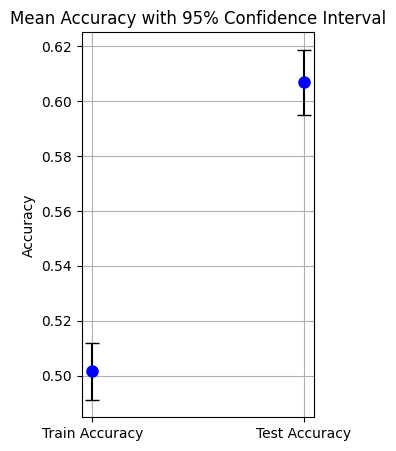

In [22]:
means = [mean_train_acc, mean_test_acc]
lower_errors = [mean_train_acc - ci_lower_train, mean_test_acc - ci_lower_test]
upper_errors = [ci_upper_train - mean_train_acc, ci_upper_test - mean_test_acc]

# Make the error symmetric
error = np.array([lower_errors, upper_errors])

x = np.arange(len(means))  # 0 for train, 1 for test

plt.figure(figsize=(3, 5))
plt.errorbar(x, means, yerr=error, fmt='o', capsize=5, markersize=8, color='blue', ecolor='black', linestyle='none')
plt.xticks(x, ['Train Accuracy', 'Test Accuracy'])
plt.ylabel('Accuracy')
plt.title('Mean Accuracy with 95% Confidence Interval')
plt.grid(True)
plt.show()

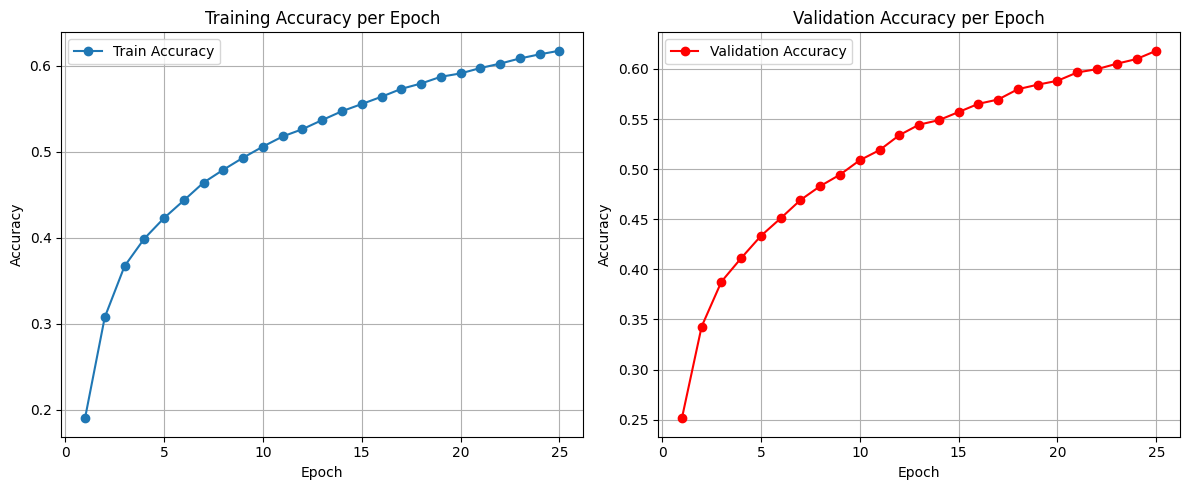

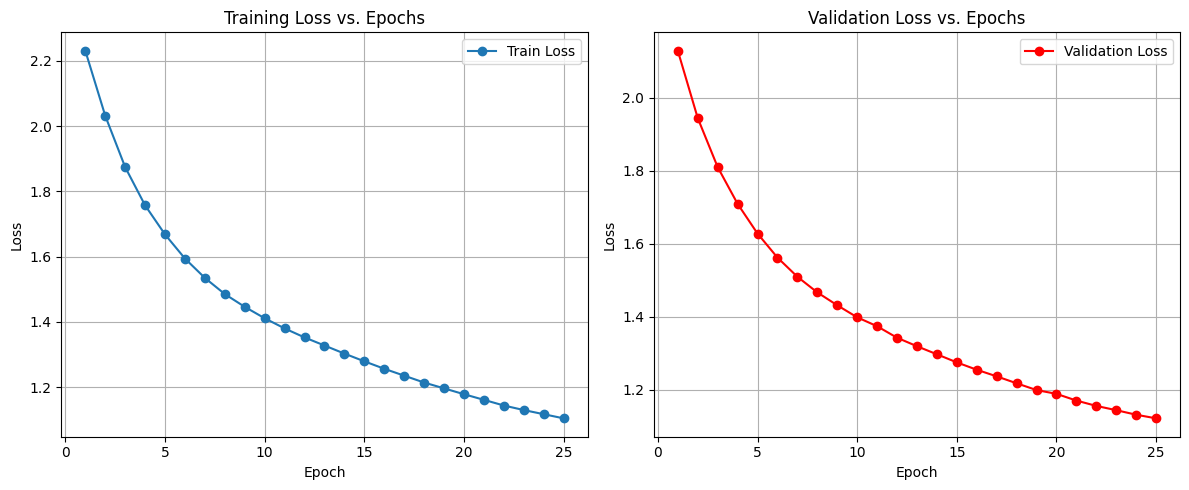

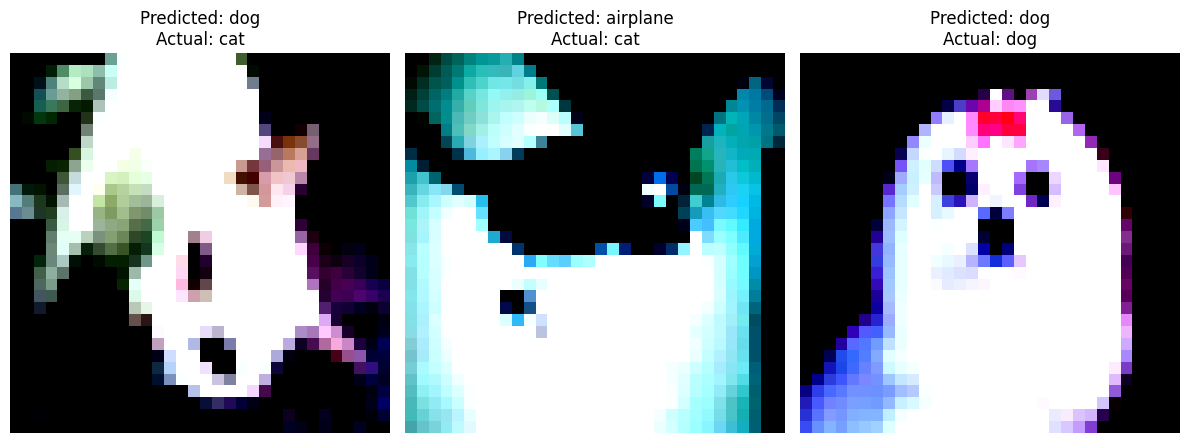

Accuracy: 0.6141
F1 Score (weighted): 0.611000101653667

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.65      0.63      1000
           1       0.72      0.78      0.75      1000
           2       0.47      0.42      0.44      1000
           3       0.46      0.43      0.45      1000
           4       0.57      0.49      0.52      1000
           5       0.52      0.55      0.53      1000
           6       0.69      0.75      0.72      1000
           7       0.67      0.67      0.67      1000
           8       0.69      0.70      0.69      1000
           9       0.71      0.71      0.71      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



In [23]:
epochs_list = np.arange(1, len(train_acc) + 1)

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_acc, label='Train Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, valid_acc, label='Validation Accuracy', marker='o',color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, valid_losses, label='Validation Loss', marker='o', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

num_img_to_show = min(3, len(all_test_images))
fig = plt.figure(figsize=(12, 6))
for i in range(num_img_to_show):
    random_index = random.randint(0, len(all_test_images) - 1)
    ax = fig.add_subplot(1, num_img_to_show, i + 1)
    ax.axis('off')
    img = all_test_images[random_index].transpose((1, 2, 0))
    ax.imshow(img)
    ax.set_title(f'Predicted: {class_names[all_preds[random_index]]}\nActual: {class_names[all_labels[random_index]]}')
plt.tight_layout()
plt.show()

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("F1 Score (weighted):", f1_score(all_labels, all_preds, average='weighted'))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

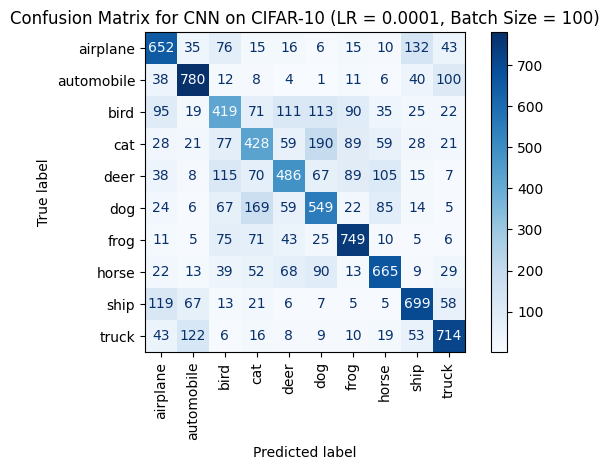

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix for CNN on CIFAR-10 (LR = 0.0001, Batch Size = 100)')
plt.tight_layout()
plt.show()

# LR = 0.5

In [25]:
from tqdm import tqdm
def train_and_evaluate(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = CNNNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Track metrics
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    test_accuracy = None

    epochs = 25
    best_valid_loss = float('inf')
    best_model_wts = None

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

        train_losses.append(train_loss / total)
        train_accuracies.append(correct / total)

        model.eval()
        valid_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

        val_loss_epoch = valid_loss / total_val
        valid_losses.append(val_loss_epoch)
        valid_accuracies.append(correct_val / total_val)

        if val_loss_epoch < best_valid_loss:
            best_valid_loss = val_loss_epoch
            best_model_wts = model.state_dict()

        print(f"Epoch {epoch:2d}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")

    # Load best model
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # Final Test Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    all_test_images = []
    correct_test = 0
    total_test = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_test_images.extend(inputs.cpu().numpy())
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    torch.cuda.empty_cache()
    return test_accuracy, train_losses, valid_losses, train_accuracies, valid_accuracies, all_test_images, all_preds, all_labels

In [26]:
import scipy.stats as st

# Training the model 5 times
run_train_accuracies = []
run_valid_accuracies = []
run_test_accuracies = []

for i in range(5):
    print(f"Running seed {i}")
    test_acc, train_losses, valid_losses, train_acc, valid_acc, all_test_images, all_preds, all_labels = train_and_evaluate(seed=i)

    run_train_accuracies.append(np.mean(train_acc))  # Mean training accuracy across epochs
    run_valid_accuracies.append(np.mean(valid_acc))  # Mean validation accuracy across epochs
    run_test_accuracies.append(test_acc)             # Final test accuracy

def compute_confidence_interval(data, alpha=0.05):
    data = np.array(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    n = len(data)
    t_critical = st.t.ppf(1 - alpha/2, df=n-1)
    half_width = t_critical * std / np.sqrt(n)
    return mean, mean - half_width, mean + half_width

# Training accuracy
mean_train_acc, ci_lower_train, ci_upper_train = compute_confidence_interval(run_train_accuracies)
print(f"\nMean Training Accuracy: {mean_train_acc:.4f}")
print(f"95% Confidence Interval (Training): ({ci_lower_train:.4f}, {ci_upper_train:.4f})")

# Validation accuracy
mean_valid_acc, ci_lower_valid, ci_upper_valid = compute_confidence_interval(run_valid_accuracies)
print(f"\nMean Validation Accuracy: {mean_valid_acc:.4f}")
print(f"95% Confidence Interval (Validation): ({ci_lower_valid:.4f}, {ci_upper_valid:.4f})")

# Test accuracy
mean_test_acc, ci_lower_test, ci_upper_test = compute_confidence_interval(run_test_accuracies)
print(f"\nMean Test Accuracy: {mean_test_acc:.4f}")
print(f"95% Confidence Interval (Test): ({ci_lower_test:.4f}, {ci_upper_test:.4f})")

Running seed 0


  4%|▍         | 1/25 [00:43<17:20, 43.34s/it]

Epoch  1, Train Loss: 2.1537, Valid Loss: 2.1372


  8%|▊         | 2/25 [01:27<16:41, 43.55s/it]

Epoch  2, Train Loss: 2.0982, Valid Loss: 2.0881


 12%|█▏        | 3/25 [02:11<16:11, 44.14s/it]

Epoch  3, Train Loss: 2.0912, Valid Loss: 2.1433


 16%|█▌        | 4/25 [02:56<15:29, 44.25s/it]

Epoch  4, Train Loss: 2.0688, Valid Loss: 2.0352


 20%|██        | 5/25 [03:40<14:43, 44.18s/it]

Epoch  5, Train Loss: 2.0738, Valid Loss: 2.0978


 24%|██▍       | 6/25 [04:24<13:58, 44.12s/it]

Epoch  6, Train Loss: 2.0783, Valid Loss: 2.3023


 28%|██▊       | 7/25 [05:08<13:13, 44.09s/it]

Epoch  7, Train Loss: 2.0561, Valid Loss: 2.1368


 32%|███▏      | 8/25 [05:52<12:30, 44.15s/it]

Epoch  8, Train Loss: 2.0668, Valid Loss: 2.0309


 36%|███▌      | 9/25 [06:37<11:50, 44.38s/it]

Epoch  9, Train Loss: 2.0605, Valid Loss: 2.1159


 40%|████      | 10/25 [07:22<11:07, 44.47s/it]

Epoch 10, Train Loss: 2.0610, Valid Loss: 2.0008


 44%|████▍     | 11/25 [08:06<10:21, 44.36s/it]

Epoch 11, Train Loss: 2.0458, Valid Loss: 2.0126


 48%|████▊     | 12/25 [08:50<09:36, 44.32s/it]

Epoch 12, Train Loss: 2.0722, Valid Loss: 2.0554


 52%|█████▏    | 13/25 [09:34<08:51, 44.32s/it]

Epoch 13, Train Loss: 2.0707, Valid Loss: 2.0610


 56%|█████▌    | 14/25 [10:19<08:07, 44.28s/it]

Epoch 14, Train Loss: 2.0399, Valid Loss: 2.0783


 60%|██████    | 15/25 [11:04<07:24, 44.50s/it]

Epoch 15, Train Loss: 2.0547, Valid Loss: 1.9894


 64%|██████▍   | 16/25 [11:48<06:41, 44.57s/it]

Epoch 16, Train Loss: 2.0471, Valid Loss: 2.0135


 68%|██████▊   | 17/25 [12:32<05:55, 44.44s/it]

Epoch 17, Train Loss: 2.0437, Valid Loss: 2.0136


 72%|███████▏  | 18/25 [13:17<05:10, 44.42s/it]

Epoch 18, Train Loss: 2.0532, Valid Loss: 2.0304


 76%|███████▌  | 19/25 [14:01<04:26, 44.43s/it]

Epoch 19, Train Loss: 2.0672, Valid Loss: 2.0372


 80%|████████  | 20/25 [14:46<03:41, 44.38s/it]

Epoch 20, Train Loss: 2.0484, Valid Loss: 2.0432


 84%|████████▍ | 21/25 [15:31<02:58, 44.60s/it]

Epoch 21, Train Loss: 2.0330, Valid Loss: 2.0693


 88%|████████▊ | 22/25 [16:15<02:13, 44.60s/it]

Epoch 22, Train Loss: 2.0474, Valid Loss: 2.0396


 92%|█████████▏| 23/25 [16:59<01:28, 44.46s/it]

Epoch 23, Train Loss: 2.0514, Valid Loss: 2.0311


 96%|█████████▌| 24/25 [17:43<00:44, 44.30s/it]

Epoch 24, Train Loss: 2.0402, Valid Loss: 2.0168


100%|██████████| 25/25 [18:27<00:00, 44.31s/it]

Epoch 25, Train Loss: 2.0508, Valid Loss: 2.0523


Running seed 1


  4%|▍         | 1/25 [00:45<18:14, 45.59s/it]

Epoch  1, Train Loss: 2.1312, Valid Loss: 2.1175


  8%|▊         | 2/25 [01:28<16:47, 43.80s/it]

Epoch  2, Train Loss: 2.2562, Valid Loss: 2.2811


 12%|█▏        | 3/25 [02:12<16:11, 44.16s/it]

Epoch  3, Train Loss: 2.2135, Valid Loss: 2.1388


 16%|█▌        | 4/25 [02:55<15:13, 43.50s/it]

Epoch  4, Train Loss: 2.1416, Valid Loss: 2.0955


 20%|██        | 5/25 [03:39<14:36, 43.80s/it]

Epoch  5, Train Loss: 2.2098, Valid Loss: 2.1589


 24%|██▍       | 6/25 [04:22<13:44, 43.40s/it]

Epoch  6, Train Loss: 2.1423, Valid Loss: 2.0900


 28%|██▊       | 7/25 [05:04<12:56, 43.11s/it]

Epoch  7, Train Loss: 2.1062, Valid Loss: 2.0751


 32%|███▏      | 8/25 [05:48<12:17, 43.39s/it]

Epoch  8, Train Loss: 2.1205, Valid Loss: 2.2331


 36%|███▌      | 9/25 [06:33<11:41, 43.85s/it]

Epoch  9, Train Loss: 2.1261, Valid Loss: 2.0780


 40%|████      | 10/25 [07:15<10:51, 43.40s/it]

Epoch 10, Train Loss: 2.2774, Valid Loss: 2.2698


 44%|████▍     | 11/25 [07:58<10:03, 43.12s/it]

Epoch 11, Train Loss: 2.2053, Valid Loss: 2.1249


 48%|████▊     | 12/25 [08:41<09:18, 42.97s/it]

Epoch 12, Train Loss: 2.1311, Valid Loss: 2.0989


 52%|█████▏    | 13/25 [09:25<08:40, 43.41s/it]

Epoch 13, Train Loss: 2.1034, Valid Loss: 2.0806


 56%|█████▌    | 14/25 [10:07<07:53, 43.08s/it]

Epoch 14, Train Loss: 2.0772, Valid Loss: 2.0860


 60%|██████    | 15/25 [10:50<07:08, 42.90s/it]

Epoch 15, Train Loss: 2.1497, Valid Loss: 2.0873


 64%|██████▍   | 16/25 [11:34<06:29, 43.30s/it]

Epoch 16, Train Loss: 2.0962, Valid Loss: 2.1121


 68%|██████▊   | 17/25 [12:16<05:43, 42.99s/it]

Epoch 17, Train Loss: 2.1100, Valid Loss: 2.2871


 72%|███████▏  | 18/25 [12:58<04:59, 42.74s/it]

Epoch 18, Train Loss: 2.1108, Valid Loss: 2.0150


 76%|███████▌  | 19/25 [13:41<04:15, 42.57s/it]

Epoch 19, Train Loss: 2.0835, Valid Loss: 2.2027


 80%|████████  | 20/25 [14:23<03:32, 42.42s/it]

Epoch 20, Train Loss: 2.0908, Valid Loss: 1.9979


 84%|████████▍ | 21/25 [15:07<02:51, 42.91s/it]

Epoch 21, Train Loss: 2.0787, Valid Loss: 2.0607


 88%|████████▊ | 22/25 [15:49<02:07, 42.64s/it]

Epoch 22, Train Loss: 2.0801, Valid Loss: 2.1266


 92%|█████████▏| 23/25 [16:32<01:25, 42.89s/it]

Epoch 23, Train Loss: 2.0692, Valid Loss: 2.2458


 96%|█████████▌| 24/25 [17:14<00:42, 42.66s/it]

Epoch 24, Train Loss: 2.0568, Valid Loss: 1.9662


100%|██████████| 25/25 [18:00<00:00, 43.20s/it]

Epoch 25, Train Loss: 2.0901, Valid Loss: 2.0026


Running seed 2


  4%|▍         | 1/25 [00:45<18:11, 45.48s/it]

Epoch  1, Train Loss: 2.2169, Valid Loss: 2.0464


  8%|▊         | 2/25 [01:31<17:28, 45.58s/it]

Epoch  2, Train Loss: 2.1106, Valid Loss: 2.0282


 12%|█▏        | 3/25 [02:17<16:50, 45.92s/it]

Epoch  3, Train Loss: 2.1318, Valid Loss: 2.0870


 16%|█▌        | 4/25 [03:02<16:00, 45.74s/it]

Epoch  4, Train Loss: 2.1090, Valid Loss: 2.0949


 20%|██        | 5/25 [03:48<15:13, 45.66s/it]

Epoch  5, Train Loss: 2.0965, Valid Loss: 2.1399


 24%|██▍       | 6/25 [04:35<14:35, 46.05s/it]

Epoch  6, Train Loss: 2.1252, Valid Loss: 2.1098


 28%|██▊       | 7/25 [05:20<13:46, 45.92s/it]

Epoch  7, Train Loss: 2.1134, Valid Loss: 2.0957


 32%|███▏      | 8/25 [06:06<12:58, 45.78s/it]

Epoch  8, Train Loss: 2.0954, Valid Loss: 2.1280


 36%|███▌      | 9/25 [06:51<12:11, 45.71s/it]

Epoch  9, Train Loss: 2.1034, Valid Loss: 2.1659


 40%|████      | 10/25 [07:38<11:30, 46.05s/it]

Epoch 10, Train Loss: 2.1319, Valid Loss: 2.0966


 44%|████▍     | 11/25 [08:24<10:42, 45.88s/it]

Epoch 11, Train Loss: 2.0708, Valid Loss: 2.0232


 48%|████▊     | 12/25 [09:09<09:55, 45.77s/it]

Epoch 12, Train Loss: 2.0676, Valid Loss: 2.0711


 52%|█████▏    | 13/25 [09:56<09:11, 45.95s/it]

Epoch 13, Train Loss: 2.0774, Valid Loss: 2.1934


 56%|█████▌    | 14/25 [10:42<08:27, 46.10s/it]

Epoch 14, Train Loss: 2.1086, Valid Loss: 2.0437


 60%|██████    | 15/25 [11:28<07:39, 46.00s/it]

Epoch 15, Train Loss: 2.0792, Valid Loss: 2.0324


 64%|██████▍   | 16/25 [12:14<06:53, 45.92s/it]

Epoch 16, Train Loss: 2.0495, Valid Loss: 2.0423


 68%|██████▊   | 17/25 [13:01<06:10, 46.26s/it]

Epoch 17, Train Loss: 2.0579, Valid Loss: 2.0451


 72%|███████▏  | 18/25 [13:46<05:22, 46.06s/it]

Epoch 18, Train Loss: 2.0973, Valid Loss: 2.0378


 76%|███████▌  | 19/25 [14:32<04:35, 45.92s/it]

Epoch 19, Train Loss: 2.0482, Valid Loss: 1.9992


 80%|████████  | 20/25 [15:18<03:49, 45.90s/it]

Epoch 20, Train Loss: 2.0723, Valid Loss: 2.0419


 84%|████████▍ | 21/25 [16:04<03:04, 46.16s/it]

Epoch 21, Train Loss: 2.0701, Valid Loss: 2.0549


 88%|████████▊ | 22/25 [16:50<02:18, 46.08s/it]

Epoch 22, Train Loss: 2.0473, Valid Loss: 2.0135


 92%|█████████▏| 23/25 [17:36<01:31, 45.90s/it]

Epoch 23, Train Loss: 2.0545, Valid Loss: 1.9958


 96%|█████████▌| 24/25 [18:22<00:46, 46.03s/it]

Epoch 24, Train Loss: 2.0411, Valid Loss: 2.1152


100%|██████████| 25/25 [19:08<00:00, 45.94s/it]

Epoch 25, Train Loss: 2.0630, Valid Loss: 2.0844


Running seed 3


  4%|▍         | 1/25 [00:47<19:00, 47.53s/it]

Epoch  1, Train Loss: 2.2696, Valid Loss: 2.2632


  8%|▊         | 2/25 [01:33<17:51, 46.57s/it]

Epoch  2, Train Loss: 2.1868, Valid Loss: 2.2693


 12%|█▏        | 3/25 [02:18<16:47, 45.78s/it]

Epoch  3, Train Loss: 2.2782, Valid Loss: 2.2427


 16%|█▌        | 4/25 [03:05<16:09, 46.17s/it]

Epoch  4, Train Loss: 2.2254, Valid Loss: 2.1944


 20%|██        | 5/25 [03:52<15:31, 46.58s/it]

Epoch  5, Train Loss: 2.1759, Valid Loss: 2.1212


 24%|██▍       | 6/25 [04:37<14:36, 46.13s/it]

Epoch  6, Train Loss: 2.1342, Valid Loss: 2.1425


 28%|██▊       | 7/25 [05:23<13:51, 46.20s/it]

Epoch  7, Train Loss: 2.1184, Valid Loss: 2.0801


 32%|███▏      | 8/25 [06:11<13:10, 46.49s/it]

Epoch  8, Train Loss: 2.1006, Valid Loss: 2.0596


 36%|███▌      | 9/25 [06:57<12:21, 46.33s/it]

Epoch  9, Train Loss: 2.2032, Valid Loss: 2.1346


 40%|████      | 10/25 [07:41<11:27, 45.82s/it]

Epoch 10, Train Loss: 2.1253, Valid Loss: 2.0471


 44%|████▍     | 11/25 [08:28<10:46, 46.21s/it]

Epoch 11, Train Loss: 2.0940, Valid Loss: 2.0502


 48%|████▊     | 12/25 [09:15<10:01, 46.28s/it]

Epoch 12, Train Loss: 2.1178, Valid Loss: 2.1159


 52%|█████▏    | 13/25 [10:01<09:14, 46.18s/it]

Epoch 13, Train Loss: 2.1130, Valid Loss: 2.0569


 56%|█████▌    | 14/25 [10:47<08:28, 46.18s/it]

Epoch 14, Train Loss: 2.0985, Valid Loss: 2.0856


 60%|██████    | 15/25 [11:34<07:44, 46.43s/it]

Epoch 15, Train Loss: 2.0765, Valid Loss: 2.2235


 64%|██████▍   | 16/25 [12:19<06:53, 45.93s/it]

Epoch 16, Train Loss: 2.0984, Valid Loss: 2.0722


 68%|██████▊   | 17/25 [13:05<06:07, 45.96s/it]

Epoch 17, Train Loss: 2.0897, Valid Loss: 2.2240


 72%|███████▏  | 18/25 [13:51<05:23, 46.21s/it]

Epoch 18, Train Loss: 2.0731, Valid Loss: 2.0927


 76%|███████▌  | 19/25 [14:37<04:35, 45.96s/it]

Epoch 19, Train Loss: 2.0873, Valid Loss: 2.0103


 80%|████████  | 20/25 [15:23<03:50, 46.12s/it]

Epoch 20, Train Loss: 2.0887, Valid Loss: 2.0061


 84%|████████▍ | 21/25 [16:10<03:05, 46.31s/it]

Epoch 21, Train Loss: 2.0770, Valid Loss: 1.9907


 88%|████████▊ | 22/25 [16:56<02:18, 46.15s/it]

Epoch 22, Train Loss: 2.0821, Valid Loss: 2.0544


 92%|█████████▏| 23/25 [17:41<01:31, 45.84s/it]

Epoch 23, Train Loss: 2.0833, Valid Loss: 2.0214


 96%|█████████▌| 24/25 [18:25<00:45, 45.42s/it]

Epoch 24, Train Loss: 2.0802, Valid Loss: 2.0233


100%|██████████| 25/25 [19:11<00:00, 46.05s/it]

Epoch 25, Train Loss: 2.0792, Valid Loss: 2.0282


Running seed 4


  4%|▍         | 1/25 [00:43<17:25, 43.55s/it]

Epoch  1, Train Loss: 2.1614, Valid Loss: 2.1001


  8%|▊         | 2/25 [01:27<16:42, 43.57s/it]

Epoch  2, Train Loss: 2.1215, Valid Loss: 2.1423


 12%|█▏        | 3/25 [02:11<16:04, 43.82s/it]

Epoch  3, Train Loss: 2.1125, Valid Loss: 2.0899


 16%|█▌        | 4/25 [02:55<15:19, 43.80s/it]

Epoch  4, Train Loss: 2.1058, Valid Loss: 2.2755


 20%|██        | 5/25 [03:39<14:41, 44.09s/it]

Epoch  5, Train Loss: 2.1030, Valid Loss: 2.1395


 24%|██▍       | 6/25 [04:24<14:02, 44.33s/it]

Epoch  6, Train Loss: 2.0844, Valid Loss: 2.0845


 28%|██▊       | 7/25 [05:08<13:15, 44.22s/it]

Epoch  7, Train Loss: 2.0933, Valid Loss: 2.0541


 32%|███▏      | 8/25 [05:52<12:31, 44.20s/it]

Epoch  8, Train Loss: 2.0780, Valid Loss: 2.0442


 36%|███▌      | 9/25 [06:36<11:46, 44.16s/it]

Epoch  9, Train Loss: 2.0851, Valid Loss: 2.0875


 40%|████      | 10/25 [07:20<11:01, 44.12s/it]

Epoch 10, Train Loss: 2.0745, Valid Loss: 2.0456


 44%|████▍     | 11/25 [08:05<10:18, 44.19s/it]

Epoch 11, Train Loss: 2.0779, Valid Loss: 2.0849


 48%|████▊     | 12/25 [08:50<09:39, 44.59s/it]

Epoch 12, Train Loss: 2.0746, Valid Loss: 2.0802


 52%|█████▏    | 13/25 [09:34<08:53, 44.44s/it]

Epoch 13, Train Loss: 2.0722, Valid Loss: 2.0527


 56%|█████▌    | 14/25 [10:18<08:07, 44.31s/it]

Epoch 14, Train Loss: 2.0711, Valid Loss: 2.0264


 60%|██████    | 15/25 [11:02<07:22, 44.26s/it]

Epoch 15, Train Loss: 2.0585, Valid Loss: 2.0698


 64%|██████▍   | 16/25 [11:46<06:38, 44.23s/it]

Epoch 16, Train Loss: 2.0681, Valid Loss: 2.1258


 68%|██████▊   | 17/25 [12:32<05:56, 44.61s/it]

Epoch 17, Train Loss: 2.0530, Valid Loss: 2.1098


 72%|███████▏  | 18/25 [13:17<05:13, 44.74s/it]

Epoch 18, Train Loss: 2.0734, Valid Loss: 2.0447


 76%|███████▌  | 19/25 [14:01<04:27, 44.59s/it]

Epoch 19, Train Loss: 2.0542, Valid Loss: 2.0297


 80%|████████  | 20/25 [14:46<03:42, 44.52s/it]

Epoch 20, Train Loss: 2.0666, Valid Loss: 2.0589


 84%|████████▍ | 21/25 [15:30<02:57, 44.45s/it]

Epoch 21, Train Loss: 2.0607, Valid Loss: 2.0639


 88%|████████▊ | 22/25 [16:14<02:13, 44.43s/it]

Epoch 22, Train Loss: 2.0635, Valid Loss: 2.0491


 92%|█████████▏| 23/25 [16:59<01:29, 44.60s/it]

Epoch 23, Train Loss: 2.0776, Valid Loss: 2.0367


 96%|█████████▌| 24/25 [17:44<00:44, 44.73s/it]

Epoch 24, Train Loss: 2.0365, Valid Loss: 2.0806


100%|██████████| 25/25 [18:29<00:00, 44.36s/it]

Epoch 25, Train Loss: 2.0448, Valid Loss: 2.0024



Mean Training Accuracy: 0.1800
95% Confidence Interval (Training): (0.1712, 0.1889)

Mean Validation Accuracy: 0.1815
95% Confidence Interval (Validation): (0.1732, 0.1898)

Mean Test Accuracy: 0.1862
95% Confidence Interval (Test): (0.1748, 0.1977)


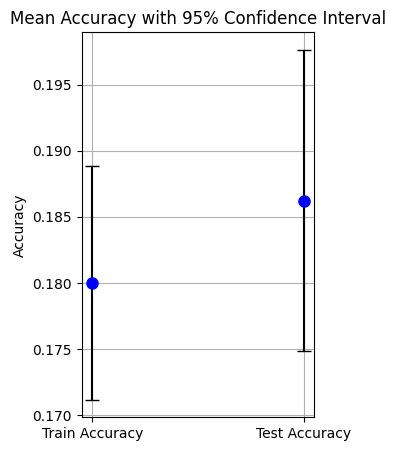

In [27]:
means = [mean_train_acc, mean_test_acc]
lower_errors = [mean_train_acc - ci_lower_train, mean_test_acc - ci_lower_test]
upper_errors = [ci_upper_train - mean_train_acc, ci_upper_test - mean_test_acc]

# Make the error symmetric
error = np.array([lower_errors, upper_errors])

x = np.arange(len(means))  # 0 for train, 1 for test

plt.figure(figsize=(3, 5))
plt.errorbar(x, means, yerr=error, fmt='o', capsize=5, markersize=8, color='blue', ecolor='black', linestyle='none')
plt.xticks(x, ['Train Accuracy', 'Test Accuracy'])
plt.ylabel('Accuracy')
plt.title('Mean Accuracy with 95% Confidence Interval')
plt.grid(True)
plt.show()

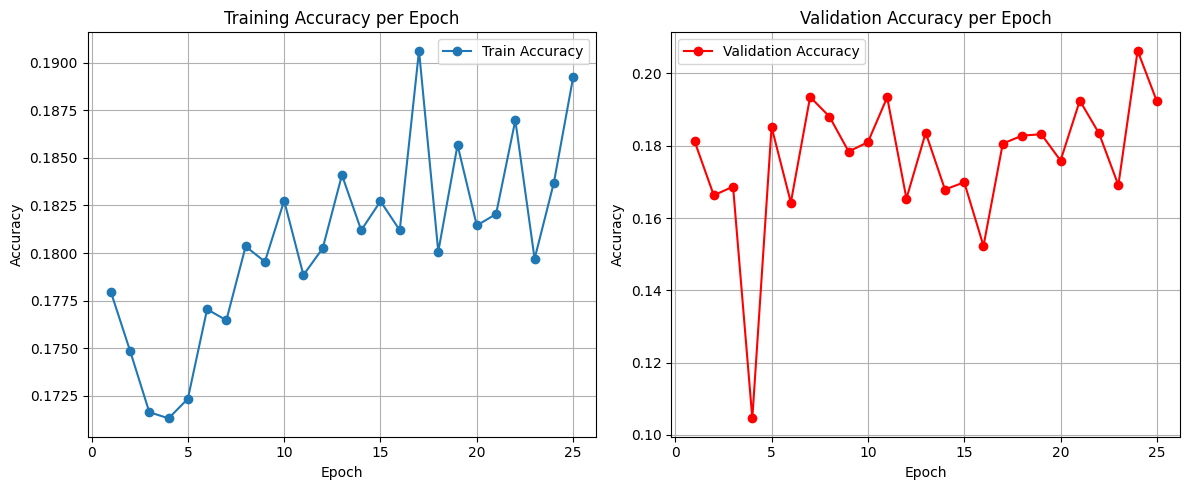

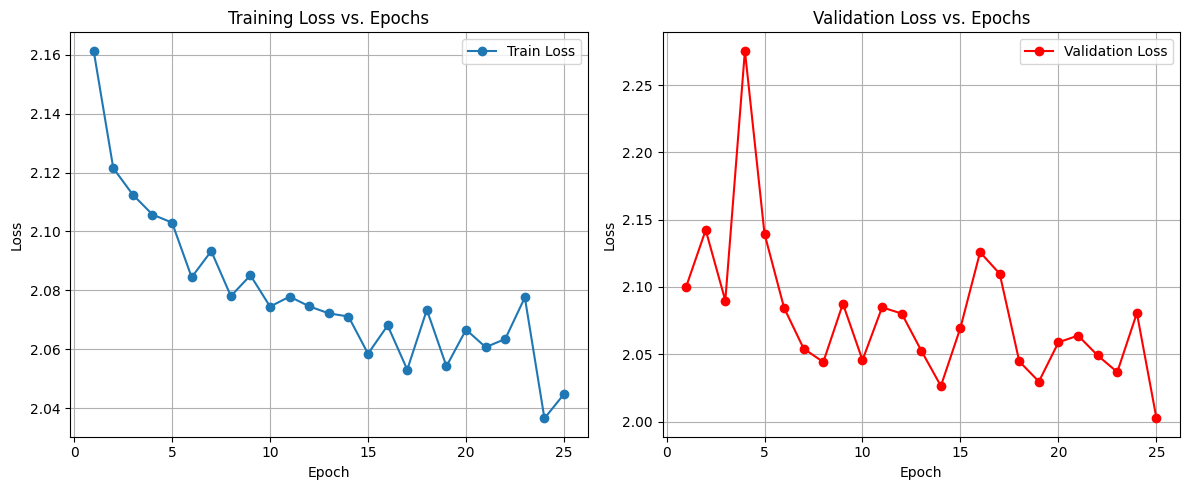

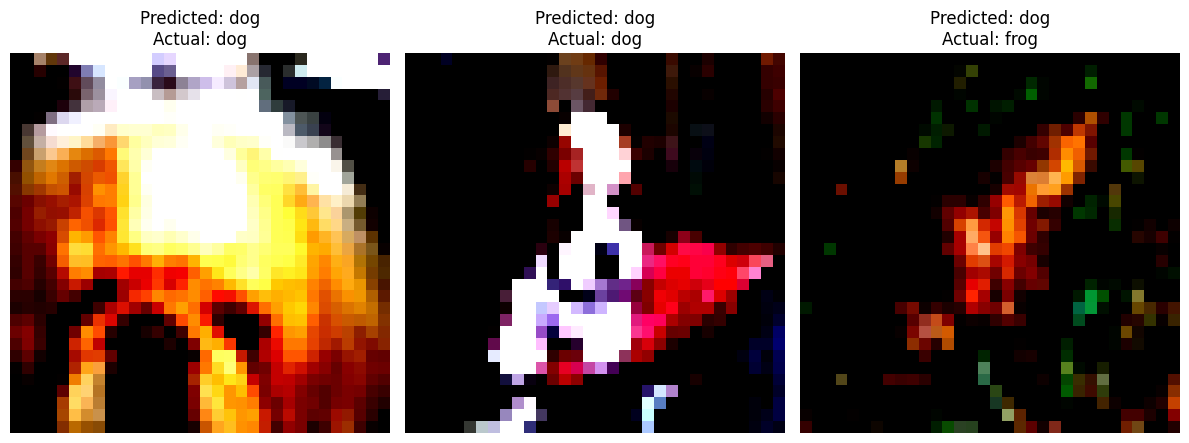

Accuracy: 0.1931
F1 Score (weighted): 0.09433552237861113

Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.00      0.01      1000
           1       0.20      0.90      0.33      1000
           2       0.09      0.01      0.01      1000
           3       0.28      0.01      0.02      1000
           4       0.04      0.00      0.00      1000
           5       0.17      0.79      0.28      1000
           6       0.00      0.00      0.00      1000
           7       0.35      0.19      0.25      1000
           8       0.06      0.00      0.00      1000
           9       0.17      0.02      0.04      1000

    accuracy                           0.19     10000
   macro avg       0.15      0.19      0.09     10000
weighted avg       0.15      0.19      0.09     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
epochs_list = np.arange(1, len(train_acc) + 1)

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_acc, label='Train Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, valid_acc, label='Validation Accuracy', marker='o',color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, valid_losses, label='Validation Loss', marker='o', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

num_img_to_show = min(3, len(all_test_images))
fig = plt.figure(figsize=(12, 6))
for i in range(num_img_to_show):
    random_index = random.randint(0, len(all_test_images) - 1)
    ax = fig.add_subplot(1, num_img_to_show, i + 1)
    ax.axis('off')
    img = all_test_images[random_index].transpose((1, 2, 0))
    ax.imshow(img)
    ax.set_title(f'Predicted: {class_names[all_preds[random_index]]}\nActual: {class_names[all_labels[random_index]]}')
plt.tight_layout()
plt.show()

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("F1 Score (weighted):", f1_score(all_labels, all_preds, average='weighted'))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

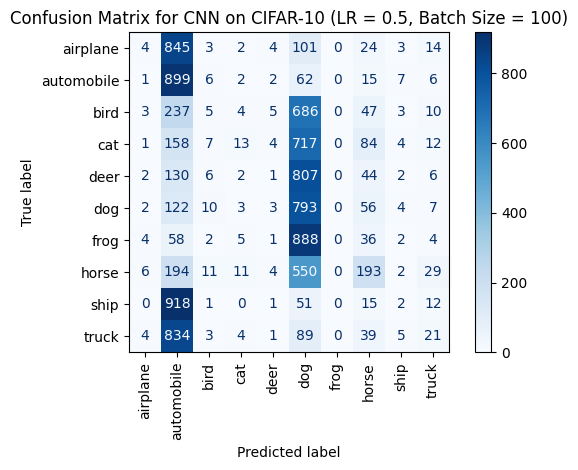

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix for CNN on CIFAR-10 (LR = 0.5, Batch Size = 100)')
plt.tight_layout()
plt.show()

# Batch Size = 20

In [30]:
# Create DataLoader
batch_size = 20

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size * 2, shuffle=False)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False)

In [31]:
from tqdm import tqdm
def train_and_evaluate(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = CNNNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Track metrics
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    test_accuracy = None

    epochs = 25
    best_valid_loss = float('inf')
    best_model_wts = None

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

        train_losses.append(train_loss / total)
        train_accuracies.append(correct / total)

        model.eval()
        valid_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

        val_loss_epoch = valid_loss / total_val
        valid_losses.append(val_loss_epoch)
        valid_accuracies.append(correct_val / total_val)

        if val_loss_epoch < best_valid_loss:
            best_valid_loss = val_loss_epoch
            best_model_wts = model.state_dict()

        print(f"Epoch {epoch:2d}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")

    # Load best model
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # Final Test Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    all_test_images = []
    correct_test = 0
    total_test = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_test_images.extend(inputs.cpu().numpy())
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    torch.cuda.empty_cache()
    return test_accuracy, train_losses, valid_losses, train_accuracies, valid_accuracies, all_test_images, all_preds, all_labels

In [32]:
import scipy.stats as st

# Training the model 5 times
run_train_accuracies = []
run_valid_accuracies = []
run_test_accuracies = []

for i in range(5):
    print(f"Running seed {i}")
    test_acc, train_losses, valid_losses, train_acc, valid_acc, all_test_images, all_preds, all_labels = train_and_evaluate(seed=i)

    run_train_accuracies.append(np.mean(train_acc))  # Mean training accuracy across epochs
    run_valid_accuracies.append(np.mean(valid_acc))  # Mean validation accuracy across epochs
    run_test_accuracies.append(test_acc)             # Final test accuracy

def compute_confidence_interval(data, alpha=0.05):
    data = np.array(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    n = len(data)
    t_critical = st.t.ppf(1 - alpha/2, df=n-1)
    half_width = t_critical * std / np.sqrt(n)
    return mean, mean - half_width, mean + half_width

# Training accuracy
mean_train_acc, ci_lower_train, ci_upper_train = compute_confidence_interval(run_train_accuracies)
print(f"\nMean Training Accuracy: {mean_train_acc:.4f}")
print(f"95% Confidence Interval (Training): ({ci_lower_train:.4f}, {ci_upper_train:.4f})")

# Validation accuracy
mean_valid_acc, ci_lower_valid, ci_upper_valid = compute_confidence_interval(run_valid_accuracies)
print(f"\nMean Validation Accuracy: {mean_valid_acc:.4f}")
print(f"95% Confidence Interval (Validation): ({ci_lower_valid:.4f}, {ci_upper_valid:.4f})")

# Test accuracy
mean_test_acc, ci_lower_test, ci_upper_test = compute_confidence_interval(run_test_accuracies)
print(f"\nMean Test Accuracy: {mean_test_acc:.4f}")
print(f"95% Confidence Interval (Test): ({ci_lower_test:.4f}, {ci_upper_test:.4f})")

Running seed 0


  4%|▍         | 1/25 [00:50<20:16, 50.69s/it]

Epoch  1, Train Loss: 1.4368, Valid Loss: 1.2129


  8%|▊         | 2/25 [01:40<19:14, 50.21s/it]

Epoch  2, Train Loss: 1.1094, Valid Loss: 1.0454


 12%|█▏        | 3/25 [02:31<18:31, 50.53s/it]

Epoch  3, Train Loss: 0.9917, Valid Loss: 1.0329


 16%|█▌        | 4/25 [03:23<17:54, 51.19s/it]

Epoch  4, Train Loss: 0.9131, Valid Loss: 0.9264


 20%|██        | 5/25 [04:14<16:59, 50.98s/it]

Epoch  5, Train Loss: 0.8528, Valid Loss: 0.9001


 24%|██▍       | 6/25 [05:05<16:12, 51.19s/it]

Epoch  6, Train Loss: 0.7964, Valid Loss: 0.8873


 28%|██▊       | 7/25 [05:57<15:22, 51.27s/it]

Epoch  7, Train Loss: 0.7497, Valid Loss: 0.8435


 32%|███▏      | 8/25 [06:47<14:28, 51.08s/it]

Epoch  8, Train Loss: 0.7076, Valid Loss: 0.8389


 36%|███▌      | 9/25 [07:39<13:38, 51.18s/it]

Epoch  9, Train Loss: 0.6670, Valid Loss: 0.8400


 40%|████      | 10/25 [08:30<12:45, 51.03s/it]

Epoch 10, Train Loss: 0.6411, Valid Loss: 0.8441


 44%|████▍     | 11/25 [09:21<11:55, 51.12s/it]

Epoch 11, Train Loss: 0.6066, Valid Loss: 0.8224


 48%|████▊     | 12/25 [10:12<11:05, 51.21s/it]

Epoch 12, Train Loss: 0.5800, Valid Loss: 0.8462


 52%|█████▏    | 13/25 [11:02<10:10, 50.84s/it]

Epoch 13, Train Loss: 0.5527, Valid Loss: 0.8602


 56%|█████▌    | 14/25 [11:54<09:20, 50.95s/it]

Epoch 14, Train Loss: 0.5262, Valid Loss: 0.8742


 60%|██████    | 15/25 [12:44<08:28, 50.90s/it]

Epoch 15, Train Loss: 0.4980, Valid Loss: 0.8379


 64%|██████▍   | 16/25 [13:35<07:38, 50.89s/it]

Epoch 16, Train Loss: 0.4733, Valid Loss: 0.9029


 68%|██████▊   | 17/25 [14:26<06:47, 50.97s/it]

Epoch 17, Train Loss: 0.4594, Valid Loss: 0.9040


 72%|███████▏  | 18/25 [15:16<05:53, 50.56s/it]

Epoch 18, Train Loss: 0.4336, Valid Loss: 0.9258


 76%|███████▌  | 19/25 [16:06<05:03, 50.55s/it]

Epoch 19, Train Loss: 0.4145, Valid Loss: 0.9505


 80%|████████  | 20/25 [16:56<04:10, 50.19s/it]

Epoch 20, Train Loss: 0.3928, Valid Loss: 0.9442


 84%|████████▍ | 21/25 [17:46<03:21, 50.26s/it]

Epoch 21, Train Loss: 0.3681, Valid Loss: 0.9521


 88%|████████▊ | 22/25 [18:37<02:30, 50.33s/it]

Epoch 22, Train Loss: 0.3517, Valid Loss: 0.9922


 92%|█████████▏| 23/25 [19:27<01:40, 50.36s/it]

Epoch 23, Train Loss: 0.3392, Valid Loss: 1.0260


 96%|█████████▌| 24/25 [20:19<00:50, 50.68s/it]

Epoch 24, Train Loss: 0.3223, Valid Loss: 1.0355


100%|██████████| 25/25 [21:08<00:00, 50.75s/it]

Epoch 25, Train Loss: 0.3083, Valid Loss: 1.0503


Running seed 1


  4%|▍         | 1/25 [00:50<20:07, 50.30s/it]

Epoch  1, Train Loss: 1.4526, Valid Loss: 1.2417


  8%|▊         | 2/25 [01:41<19:30, 50.89s/it]

Epoch  2, Train Loss: 1.1179, Valid Loss: 1.0751


 12%|█▏        | 3/25 [02:33<18:46, 51.22s/it]

Epoch  3, Train Loss: 0.9975, Valid Loss: 1.0308


 16%|█▌        | 4/25 [03:23<17:49, 50.91s/it]

Epoch  4, Train Loss: 0.9260, Valid Loss: 0.9553


 20%|██        | 5/25 [04:15<17:05, 51.28s/it]

Epoch  5, Train Loss: 0.8604, Valid Loss: 0.9398


 24%|██▍       | 6/25 [05:06<16:14, 51.29s/it]

Epoch  6, Train Loss: 0.8057, Valid Loss: 0.9112


 28%|██▊       | 7/25 [05:57<15:17, 50.96s/it]

Epoch  7, Train Loss: 0.7618, Valid Loss: 0.8797


 32%|███▏      | 8/25 [06:48<14:27, 51.05s/it]

Epoch  8, Train Loss: 0.7239, Valid Loss: 0.8508


 36%|███▌      | 9/25 [07:38<13:30, 50.66s/it]

Epoch  9, Train Loss: 0.6830, Valid Loss: 0.8579


 40%|████      | 10/25 [08:29<12:41, 50.76s/it]

Epoch 10, Train Loss: 0.6553, Valid Loss: 0.8474


 44%|████▍     | 11/25 [09:19<11:50, 50.75s/it]

Epoch 11, Train Loss: 0.6185, Valid Loss: 0.8707


 48%|████▊     | 12/25 [10:10<10:57, 50.56s/it]

Epoch 12, Train Loss: 0.5908, Valid Loss: 0.8579


 52%|█████▏    | 13/25 [11:01<10:09, 50.76s/it]

Epoch 13, Train Loss: 0.5612, Valid Loss: 0.8476


 56%|█████▌    | 14/25 [11:51<09:15, 50.52s/it]

Epoch 14, Train Loss: 0.5405, Valid Loss: 0.8473


 60%|██████    | 15/25 [12:42<08:26, 50.67s/it]

Epoch 15, Train Loss: 0.5154, Valid Loss: 0.8683


 64%|██████▍   | 16/25 [13:33<07:38, 50.89s/it]

Epoch 16, Train Loss: 0.4922, Valid Loss: 0.9043


 68%|██████▊   | 17/25 [14:23<06:45, 50.69s/it]

Epoch 17, Train Loss: 0.4689, Valid Loss: 0.8894


 72%|███████▏  | 18/25 [15:15<05:56, 50.97s/it]

Epoch 18, Train Loss: 0.4461, Valid Loss: 0.9376


 76%|███████▌  | 19/25 [16:07<05:07, 51.17s/it]

Epoch 19, Train Loss: 0.4281, Valid Loss: 0.9384


 80%|████████  | 20/25 [16:57<04:15, 51.04s/it]

Epoch 20, Train Loss: 0.3991, Valid Loss: 0.9583


 84%|████████▍ | 21/25 [17:49<03:24, 51.08s/it]

Epoch 21, Train Loss: 0.3867, Valid Loss: 0.9857


 88%|████████▊ | 22/25 [18:39<02:32, 50.83s/it]

Epoch 22, Train Loss: 0.3669, Valid Loss: 1.0174


 92%|█████████▏| 23/25 [19:30<01:42, 51.04s/it]

Epoch 23, Train Loss: 0.3538, Valid Loss: 1.0100


 96%|█████████▌| 24/25 [20:24<00:51, 51.69s/it]

Epoch 24, Train Loss: 0.3357, Valid Loss: 1.0278


100%|██████████| 25/25 [21:14<00:00, 50.97s/it]

Epoch 25, Train Loss: 0.3210, Valid Loss: 1.0819


Running seed 2


  4%|▍         | 1/25 [00:50<20:12, 50.51s/it]

Epoch  1, Train Loss: 1.4185, Valid Loss: 1.1533


  8%|▊         | 2/25 [01:42<19:35, 51.09s/it]

Epoch  2, Train Loss: 1.0909, Valid Loss: 1.0846


 12%|█▏        | 3/25 [02:33<18:48, 51.28s/it]

Epoch  3, Train Loss: 0.9828, Valid Loss: 0.9825


 16%|█▌        | 4/25 [03:23<17:49, 50.92s/it]

Epoch  4, Train Loss: 0.9090, Valid Loss: 0.9158


 20%|██        | 5/25 [04:15<17:00, 51.04s/it]

Epoch  5, Train Loss: 0.8504, Valid Loss: 0.8903


 24%|██▍       | 6/25 [05:05<16:08, 50.95s/it]

Epoch  6, Train Loss: 0.7972, Valid Loss: 0.8761


 28%|██▊       | 7/25 [05:56<15:15, 50.86s/it]

Epoch  7, Train Loss: 0.7509, Valid Loss: 0.8682


 32%|███▏      | 8/25 [06:47<14:27, 51.01s/it]

Epoch  8, Train Loss: 0.7100, Valid Loss: 0.8912


 36%|███▌      | 9/25 [07:37<13:30, 50.69s/it]

Epoch  9, Train Loss: 0.6714, Valid Loss: 0.8608


 40%|████      | 10/25 [08:29<12:42, 50.84s/it]

Epoch 10, Train Loss: 0.6424, Valid Loss: 0.8557


 44%|████▍     | 11/25 [09:19<11:51, 50.85s/it]

Epoch 11, Train Loss: 0.6123, Valid Loss: 0.8780


 48%|████▊     | 12/25 [10:10<11:00, 50.84s/it]

Epoch 12, Train Loss: 0.5809, Valid Loss: 0.8609


 52%|█████▏    | 13/25 [11:01<10:10, 50.91s/it]

Epoch 13, Train Loss: 0.5511, Valid Loss: 0.8879


 56%|█████▌    | 14/25 [11:53<09:21, 51.02s/it]

Epoch 14, Train Loss: 0.5273, Valid Loss: 0.8614


 60%|██████    | 15/25 [12:44<08:31, 51.13s/it]

Epoch 15, Train Loss: 0.5029, Valid Loss: 0.8744


 64%|██████▍   | 16/25 [13:36<07:41, 51.25s/it]

Epoch 16, Train Loss: 0.4751, Valid Loss: 0.9235


 68%|██████▊   | 17/25 [14:26<06:47, 50.89s/it]

Epoch 17, Train Loss: 0.4525, Valid Loss: 0.9384


 72%|███████▏  | 18/25 [15:17<05:56, 50.99s/it]

Epoch 18, Train Loss: 0.4346, Valid Loss: 0.9269


 76%|███████▌  | 19/25 [16:07<05:04, 50.80s/it]

Epoch 19, Train Loss: 0.4105, Valid Loss: 0.9450


 80%|████████  | 20/25 [16:58<04:13, 50.66s/it]

Epoch 20, Train Loss: 0.3912, Valid Loss: 1.0174


 84%|████████▍ | 21/25 [17:49<03:23, 50.76s/it]

Epoch 21, Train Loss: 0.3753, Valid Loss: 1.0221


 88%|████████▊ | 22/25 [18:38<02:31, 50.42s/it]

Epoch 22, Train Loss: 0.3551, Valid Loss: 1.0224


 92%|█████████▏| 23/25 [19:29<01:41, 50.58s/it]

Epoch 23, Train Loss: 0.3345, Valid Loss: 1.0710


 96%|█████████▌| 24/25 [20:19<00:50, 50.51s/it]

Epoch 24, Train Loss: 0.3273, Valid Loss: 1.0694


100%|██████████| 25/25 [21:11<00:00, 50.85s/it]

Epoch 25, Train Loss: 0.3037, Valid Loss: 1.0935


Running seed 3


  4%|▍         | 1/25 [00:51<20:30, 51.27s/it]

Epoch  1, Train Loss: 1.4523, Valid Loss: 1.1929


  8%|▊         | 2/25 [01:43<19:47, 51.62s/it]

Epoch  2, Train Loss: 1.1101, Valid Loss: 1.1313


 12%|█▏        | 3/25 [02:33<18:46, 51.21s/it]

Epoch  3, Train Loss: 1.0057, Valid Loss: 0.9891


 16%|█▌        | 4/25 [03:25<18:01, 51.51s/it]

Epoch  4, Train Loss: 0.9322, Valid Loss: 0.9925


 20%|██        | 5/25 [04:18<17:17, 51.88s/it]

Epoch  5, Train Loss: 0.8725, Valid Loss: 0.9237


 24%|██▍       | 6/25 [05:08<16:16, 51.42s/it]

Epoch  6, Train Loss: 0.8233, Valid Loss: 0.8963


 28%|██▊       | 7/25 [06:00<15:26, 51.46s/it]

Epoch  7, Train Loss: 0.7833, Valid Loss: 0.8836


 32%|███▏      | 8/25 [06:51<14:35, 51.48s/it]

Epoch  8, Train Loss: 0.7421, Valid Loss: 0.8662


 36%|███▌      | 9/25 [07:42<13:37, 51.10s/it]

Epoch  9, Train Loss: 0.7058, Valid Loss: 0.8850


 40%|████      | 10/25 [08:33<12:48, 51.22s/it]

Epoch 10, Train Loss: 0.6708, Valid Loss: 0.8688


 44%|████▍     | 11/25 [09:25<11:58, 51.32s/it]

Epoch 11, Train Loss: 0.6474, Valid Loss: 0.8486


 48%|████▊     | 12/25 [10:15<11:04, 51.10s/it]

Epoch 12, Train Loss: 0.6156, Valid Loss: 0.9013


 52%|█████▏    | 13/25 [11:07<10:15, 51.33s/it]

Epoch 13, Train Loss: 0.5861, Valid Loss: 0.8700


 56%|█████▌    | 14/25 [11:58<09:23, 51.26s/it]

Epoch 14, Train Loss: 0.5587, Valid Loss: 0.8894


 60%|██████    | 15/25 [12:49<08:31, 51.19s/it]

Epoch 15, Train Loss: 0.5353, Valid Loss: 0.8793


 64%|██████▍   | 16/25 [13:41<07:42, 51.35s/it]

Epoch 16, Train Loss: 0.5142, Valid Loss: 0.9001


 68%|██████▊   | 17/25 [14:32<06:49, 51.13s/it]

Epoch 17, Train Loss: 0.4876, Valid Loss: 0.9332


 72%|███████▏  | 18/25 [15:23<05:58, 51.23s/it]

Epoch 18, Train Loss: 0.4656, Valid Loss: 0.9372


 76%|███████▌  | 19/25 [16:15<05:08, 51.41s/it]

Epoch 19, Train Loss: 0.4476, Valid Loss: 0.9501


 80%|████████  | 20/25 [17:05<04:15, 51.01s/it]

Epoch 20, Train Loss: 0.4283, Valid Loss: 0.9553


 84%|████████▍ | 21/25 [17:57<03:24, 51.22s/it]

Epoch 21, Train Loss: 0.4088, Valid Loss: 1.0337


 88%|████████▊ | 22/25 [18:48<02:33, 51.28s/it]

Epoch 22, Train Loss: 0.3866, Valid Loss: 1.0014


 92%|█████████▏| 23/25 [19:39<01:42, 51.02s/it]

Epoch 23, Train Loss: 0.3687, Valid Loss: 0.9916


 96%|█████████▌| 24/25 [20:30<00:51, 51.13s/it]

Epoch 24, Train Loss: 0.3489, Valid Loss: 1.0380


100%|██████████| 25/25 [21:20<00:00, 51.23s/it]

Epoch 25, Train Loss: 0.3421, Valid Loss: 1.0552


Running seed 4


  4%|▍         | 1/25 [00:49<19:52, 49.69s/it]

Epoch  1, Train Loss: 1.4442, Valid Loss: 1.1664


  8%|▊         | 2/25 [01:40<19:21, 50.49s/it]

Epoch  2, Train Loss: 1.1138, Valid Loss: 1.0569


 12%|█▏        | 3/25 [02:31<18:35, 50.71s/it]

Epoch  3, Train Loss: 0.9981, Valid Loss: 0.9947


 16%|█▌        | 4/25 [03:21<17:40, 50.49s/it]

Epoch  4, Train Loss: 0.9189, Valid Loss: 0.9358


 20%|██        | 5/25 [04:12<16:53, 50.68s/it]

Epoch  5, Train Loss: 0.8558, Valid Loss: 0.8954


 24%|██▍       | 6/25 [05:02<15:57, 50.42s/it]

Epoch  6, Train Loss: 0.8034, Valid Loss: 0.8975


 28%|██▊       | 7/25 [05:53<15:09, 50.55s/it]

Epoch  7, Train Loss: 0.7590, Valid Loss: 0.8651


 32%|███▏      | 8/25 [06:44<14:19, 50.58s/it]

Epoch  8, Train Loss: 0.7167, Valid Loss: 0.8393


 36%|███▌      | 9/25 [07:34<13:27, 50.47s/it]

Epoch  9, Train Loss: 0.6828, Valid Loss: 0.8615


 40%|████      | 10/25 [08:25<12:39, 50.66s/it]

Epoch 10, Train Loss: 0.6503, Valid Loss: 0.8730


 44%|████▍     | 11/25 [09:15<11:45, 50.40s/it]

Epoch 11, Train Loss: 0.6195, Valid Loss: 0.8151


 48%|████▊     | 12/25 [10:06<10:56, 50.49s/it]

Epoch 12, Train Loss: 0.5878, Valid Loss: 0.8274


 52%|█████▏    | 13/25 [10:55<10:03, 50.31s/it]

Epoch 13, Train Loss: 0.5629, Valid Loss: 0.8672


 56%|█████▌    | 14/25 [11:46<09:14, 50.39s/it]

Epoch 14, Train Loss: 0.5317, Valid Loss: 0.8343


 60%|██████    | 15/25 [12:36<08:24, 50.41s/it]

Epoch 15, Train Loss: 0.5102, Valid Loss: 0.8430


 64%|██████▍   | 16/25 [13:26<07:31, 50.20s/it]

Epoch 16, Train Loss: 0.4801, Valid Loss: 0.8763


 68%|██████▊   | 17/25 [14:18<06:44, 50.61s/it]

Epoch 17, Train Loss: 0.4606, Valid Loss: 0.9026


 72%|███████▏  | 18/25 [15:08<05:52, 50.41s/it]

Epoch 18, Train Loss: 0.4342, Valid Loss: 0.9511


 76%|███████▌  | 19/25 [15:59<05:03, 50.65s/it]

Epoch 19, Train Loss: 0.4217, Valid Loss: 0.9080


 80%|████████  | 20/25 [16:50<04:14, 50.83s/it]

Epoch 20, Train Loss: 0.3978, Valid Loss: 0.9135


 84%|████████▍ | 21/25 [17:40<03:22, 50.67s/it]

Epoch 21, Train Loss: 0.3784, Valid Loss: 0.9661


 88%|████████▊ | 22/25 [18:32<02:32, 50.84s/it]

Epoch 22, Train Loss: 0.3585, Valid Loss: 0.9808


 92%|█████████▏| 23/25 [19:21<01:40, 50.50s/it]

Epoch 23, Train Loss: 0.3428, Valid Loss: 1.0093


 96%|█████████▌| 24/25 [20:12<00:50, 50.59s/it]

Epoch 24, Train Loss: 0.3334, Valid Loss: 1.0229


100%|██████████| 25/25 [21:02<00:00, 50.52s/it]

Epoch 25, Train Loss: 0.3115, Valid Loss: 1.0822



Mean Training Accuracy: 0.7791
95% Confidence Interval (Training): (0.7740, 0.7843)

Mean Validation Accuracy: 0.6969
95% Confidence Interval (Validation): (0.6914, 0.7024)

Mean Test Accuracy: 0.7089
95% Confidence Interval (Test): (0.7048, 0.7129)


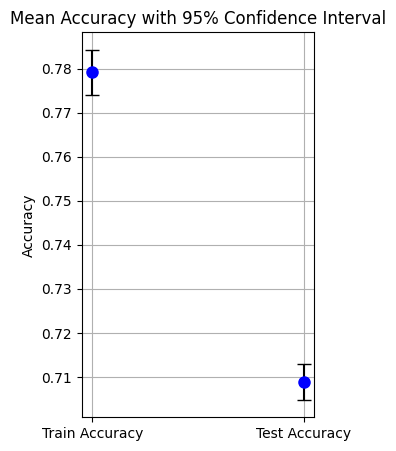

In [33]:
means = [mean_train_acc, mean_test_acc]
lower_errors = [mean_train_acc - ci_lower_train, mean_test_acc - ci_lower_test]
upper_errors = [ci_upper_train - mean_train_acc, ci_upper_test - mean_test_acc]

# Make the error symmetric
error = np.array([lower_errors, upper_errors])

x = np.arange(len(means))  # 0 for train, 1 for test

plt.figure(figsize=(3, 5))
plt.errorbar(x, means, yerr=error, fmt='o', capsize=5, markersize=8, color='blue', ecolor='black', linestyle='none')
plt.xticks(x, ['Train Accuracy', 'Test Accuracy'])
plt.ylabel('Accuracy')
plt.title('Mean Accuracy with 95% Confidence Interval')
plt.grid(True)
plt.show()

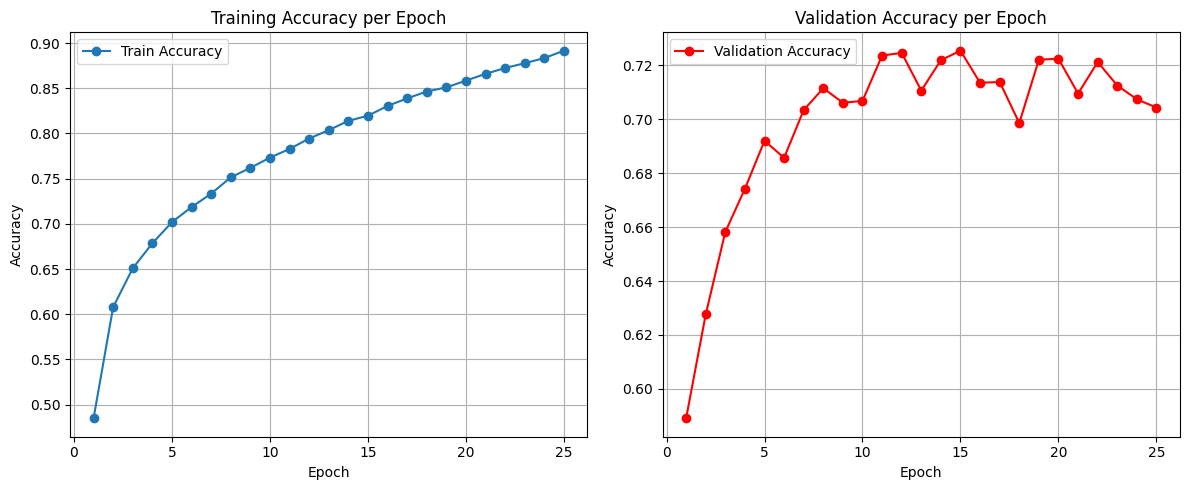

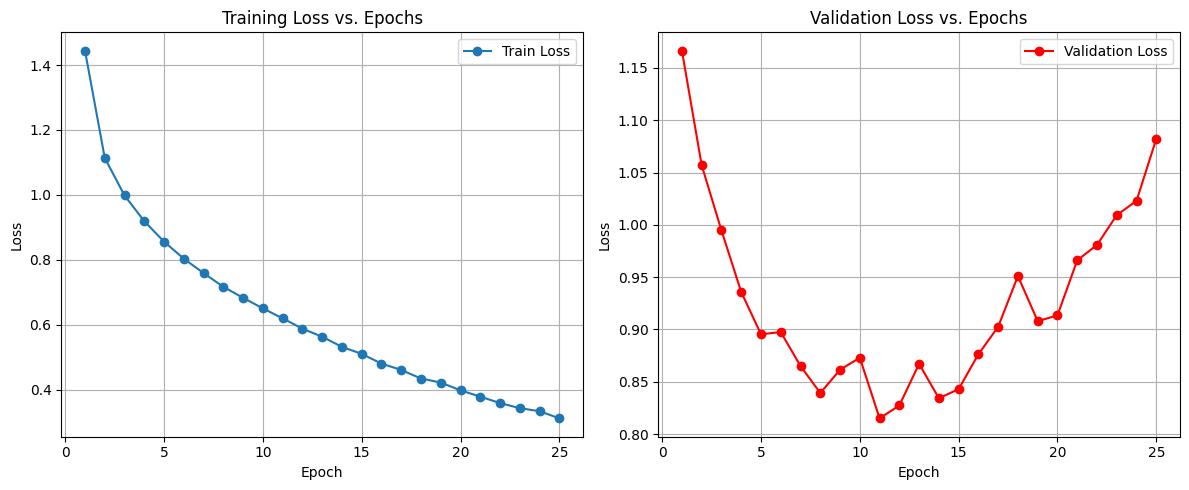

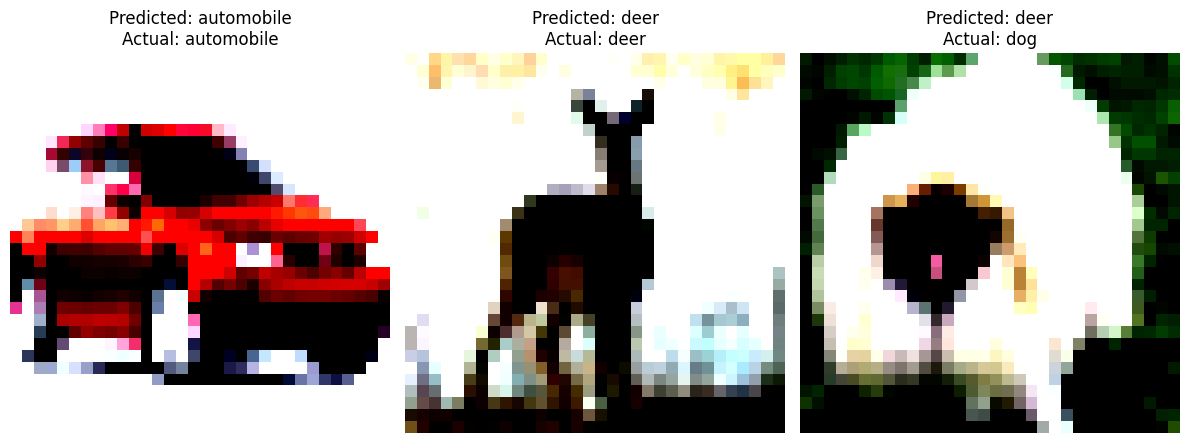

Accuracy: 0.7043
F1 Score (weighted): 0.703641443465399

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74      1000
           1       0.81      0.84      0.82      1000
           2       0.58      0.64      0.61      1000
           3       0.60      0.44      0.50      1000
           4       0.65      0.69      0.67      1000
           5       0.55      0.71      0.62      1000
           6       0.70      0.85      0.77      1000
           7       0.84      0.67      0.75      1000
           8       0.82      0.80      0.81      1000
           9       0.85      0.68      0.76      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



In [34]:
epochs_list = np.arange(1, len(train_acc) + 1)

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_acc, label='Train Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, valid_acc, label='Validation Accuracy', marker='o',color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, valid_losses, label='Validation Loss', marker='o', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

num_img_to_show = min(3, len(all_test_images))
fig = plt.figure(figsize=(12, 6))
for i in range(num_img_to_show):
    random_index = random.randint(0, len(all_test_images) - 1)
    ax = fig.add_subplot(1, num_img_to_show, i + 1)
    ax.axis('off')
    img = all_test_images[random_index].transpose((1, 2, 0))
    ax.imshow(img)
    ax.set_title(f'Predicted: {class_names[all_preds[random_index]]}\nActual: {class_names[all_labels[random_index]]}')
plt.tight_layout()
plt.show()

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("F1 Score (weighted):", f1_score(all_labels, all_preds, average='weighted'))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

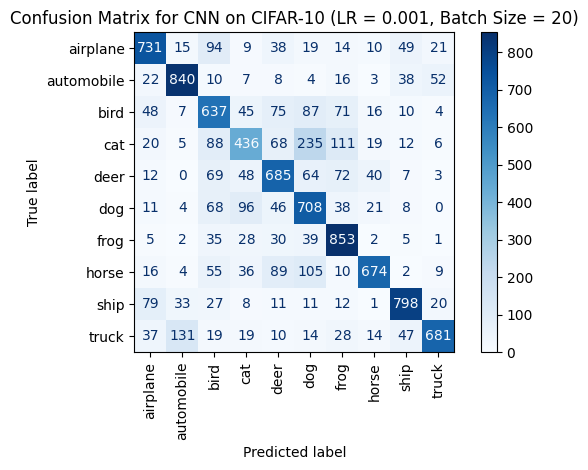

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix for CNN on CIFAR-10 (LR = 0.001, Batch Size = 20)')
plt.tight_layout()
plt.show()

#  Batch Size = 500

In [36]:
# Create DataLoader
batch_size = 500

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size * 2, shuffle=False)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False)

In [37]:
from tqdm import tqdm
def train_and_evaluate(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = CNNNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Track metrics
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    test_accuracy = None

    epochs = 25
    best_valid_loss = float('inf')
    best_model_wts = None

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

        train_losses.append(train_loss / total)
        train_accuracies.append(correct / total)

        model.eval()
        valid_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

        val_loss_epoch = valid_loss / total_val
        valid_losses.append(val_loss_epoch)
        valid_accuracies.append(correct_val / total_val)

        if val_loss_epoch < best_valid_loss:
            best_valid_loss = val_loss_epoch
            best_model_wts = model.state_dict()

        print(f"Epoch {epoch:2d}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")

    # Load best model
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # Final Test Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    all_test_images = []
    correct_test = 0
    total_test = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_test_images.extend(inputs.cpu().numpy())
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    torch.cuda.empty_cache()
    return test_accuracy, train_losses, valid_losses, train_accuracies, valid_accuracies, all_test_images, all_preds, all_labels

In [38]:
import scipy.stats as st

# Training the model 5 times
run_train_accuracies = []
run_valid_accuracies = []
run_test_accuracies = []

for i in range(5):
    print(f"Running seed {i}")
    test_acc, train_losses, valid_losses, train_acc, valid_acc, all_test_images, all_preds, all_labels = train_and_evaluate(seed=i)

    run_train_accuracies.append(np.mean(train_acc))  # Mean training accuracy across epochs
    run_valid_accuracies.append(np.mean(valid_acc))  # Mean validation accuracy across epochs
    run_test_accuracies.append(test_acc)             # Final test accuracy

def compute_confidence_interval(data, alpha=0.05):
    data = np.array(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    n = len(data)
    t_critical = st.t.ppf(1 - alpha/2, df=n-1)
    half_width = t_critical * std / np.sqrt(n)
    return mean, mean - half_width, mean + half_width

# Training accuracy
mean_train_acc, ci_lower_train, ci_upper_train = compute_confidence_interval(run_train_accuracies)
print(f"\nMean Training Accuracy: {mean_train_acc:.4f}")
print(f"95% Confidence Interval (Training): ({ci_lower_train:.4f}, {ci_upper_train:.4f})")

# Validation accuracy
mean_valid_acc, ci_lower_valid, ci_upper_valid = compute_confidence_interval(run_valid_accuracies)
print(f"\nMean Validation Accuracy: {mean_valid_acc:.4f}")
print(f"95% Confidence Interval (Validation): ({ci_lower_valid:.4f}, {ci_upper_valid:.4f})")

# Test accuracy
mean_test_acc, ci_lower_test, ci_upper_test = compute_confidence_interval(run_test_accuracies)
print(f"\nMean Test Accuracy: {mean_test_acc:.4f}")
print(f"95% Confidence Interval (Test): ({ci_lower_test:.4f}, {ci_upper_test:.4f})")

Running seed 0


  4%|▍         | 1/25 [01:05<26:05, 65.21s/it]

Epoch  1, Train Loss: 2.1474, Valid Loss: 1.9650


  8%|▊         | 2/25 [02:09<24:41, 64.41s/it]

Epoch  2, Train Loss: 1.8280, Valid Loss: 1.7279


 12%|█▏        | 3/25 [03:14<23:49, 64.96s/it]

Epoch  3, Train Loss: 1.6478, Valid Loss: 1.5986


 16%|█▌        | 4/25 [04:18<22:35, 64.53s/it]

Epoch  4, Train Loss: 1.5412, Valid Loss: 1.5168


 20%|██        | 5/25 [05:22<21:23, 64.19s/it]

Epoch  5, Train Loss: 1.4666, Valid Loss: 1.4524


 24%|██▍       | 6/25 [06:27<20:24, 64.43s/it]

Epoch  6, Train Loss: 1.4091, Valid Loss: 1.3997


 28%|██▊       | 7/25 [07:30<19:13, 64.06s/it]

Epoch  7, Train Loss: 1.3586, Valid Loss: 1.3527


 32%|███▏      | 8/25 [08:34<18:10, 64.13s/it]

Epoch  8, Train Loss: 1.3138, Valid Loss: 1.3104


 36%|███▌      | 9/25 [09:38<17:02, 63.90s/it]

Epoch  9, Train Loss: 1.2704, Valid Loss: 1.2747


 40%|████      | 10/25 [10:42<16:02, 64.17s/it]

Epoch 10, Train Loss: 1.2315, Valid Loss: 1.2366


 44%|████▍     | 11/25 [11:47<15:00, 64.35s/it]

Epoch 11, Train Loss: 1.1973, Valid Loss: 1.2082


 48%|████▊     | 12/25 [12:50<13:51, 63.99s/it]

Epoch 12, Train Loss: 1.1681, Valid Loss: 1.1796


 52%|█████▏    | 13/25 [13:55<12:52, 64.37s/it]

Epoch 13, Train Loss: 1.1400, Valid Loss: 1.1617


 56%|█████▌    | 14/25 [14:59<11:46, 64.24s/it]

Epoch 14, Train Loss: 1.1155, Valid Loss: 1.1458


 60%|██████    | 15/25 [16:04<10:43, 64.31s/it]

Epoch 15, Train Loss: 1.0924, Valid Loss: 1.1186


 64%|██████▍   | 16/25 [17:09<09:40, 64.51s/it]

Epoch 16, Train Loss: 1.0726, Valid Loss: 1.1109


 68%|██████▊   | 17/25 [18:12<08:33, 64.21s/it]

Epoch 17, Train Loss: 1.0553, Valid Loss: 1.0880


 72%|███████▏  | 18/25 [19:17<07:31, 64.44s/it]

Epoch 18, Train Loss: 1.0399, Valid Loss: 1.0781


 76%|███████▌  | 19/25 [20:22<06:27, 64.51s/it]

Epoch 19, Train Loss: 1.0199, Valid Loss: 1.0647


 80%|████████  | 20/25 [21:27<05:22, 64.52s/it]

Epoch 20, Train Loss: 1.0075, Valid Loss: 1.0729


 84%|████████▍ | 21/25 [22:32<04:18, 64.74s/it]

Epoch 21, Train Loss: 0.9942, Valid Loss: 1.0742


 88%|████████▊ | 22/25 [23:36<03:13, 64.46s/it]

Epoch 22, Train Loss: 0.9817, Valid Loss: 1.0388


 92%|█████████▏| 23/25 [24:41<02:09, 64.70s/it]

Epoch 23, Train Loss: 0.9679, Valid Loss: 1.0213


 96%|█████████▌| 24/25 [25:46<01:04, 64.70s/it]

Epoch 24, Train Loss: 0.9565, Valid Loss: 1.0262


100%|██████████| 25/25 [26:50<00:00, 64.40s/it]

Epoch 25, Train Loss: 0.9465, Valid Loss: 1.0186


Running seed 1


  4%|▍         | 1/25 [01:05<26:22, 65.94s/it]

Epoch  1, Train Loss: 2.1709, Valid Loss: 2.0038


  8%|▊         | 2/25 [02:11<25:04, 65.43s/it]

Epoch  2, Train Loss: 1.8681, Valid Loss: 1.7629


 12%|█▏        | 3/25 [03:17<24:07, 65.78s/it]

Epoch  3, Train Loss: 1.6789, Valid Loss: 1.6117


 16%|█▌        | 4/25 [04:20<22:41, 64.84s/it]

Epoch  4, Train Loss: 1.5529, Valid Loss: 1.5115


 20%|██        | 5/25 [05:23<21:23, 64.18s/it]

Epoch  5, Train Loss: 1.4671, Valid Loss: 1.4413


 24%|██▍       | 6/25 [06:27<20:17, 64.07s/it]

Epoch  6, Train Loss: 1.4044, Valid Loss: 1.3913


 28%|██▊       | 7/25 [07:30<19:04, 63.58s/it]

Epoch  7, Train Loss: 1.3547, Valid Loss: 1.3452


 32%|███▏      | 8/25 [08:33<18:01, 63.64s/it]

Epoch  8, Train Loss: 1.3120, Valid Loss: 1.3099


 36%|███▌      | 9/25 [09:36<16:54, 63.38s/it]

Epoch  9, Train Loss: 1.2756, Valid Loss: 1.2830


 40%|████      | 10/25 [10:40<15:52, 63.51s/it]

Epoch 10, Train Loss: 1.2404, Valid Loss: 1.2442


 44%|████▍     | 11/25 [11:43<14:45, 63.28s/it]

Epoch 11, Train Loss: 1.2135, Valid Loss: 1.2239


 48%|████▊     | 12/25 [12:47<13:46, 63.57s/it]

Epoch 12, Train Loss: 1.1834, Valid Loss: 1.2100


 52%|█████▏    | 13/25 [13:54<12:55, 64.59s/it]

Epoch 13, Train Loss: 1.1615, Valid Loss: 1.1827


 56%|█████▌    | 14/25 [14:57<11:44, 64.08s/it]

Epoch 14, Train Loss: 1.1374, Valid Loss: 1.1675


 60%|██████    | 15/25 [16:01<10:40, 64.09s/it]

Epoch 15, Train Loss: 1.1142, Valid Loss: 1.1381


 64%|██████▍   | 16/25 [17:04<09:34, 63.83s/it]

Epoch 16, Train Loss: 1.0928, Valid Loss: 1.1218


 68%|██████▊   | 17/25 [18:08<08:31, 63.95s/it]

Epoch 17, Train Loss: 1.0748, Valid Loss: 1.1040


 72%|███████▏  | 18/25 [19:12<07:28, 64.01s/it]

Epoch 18, Train Loss: 1.0562, Valid Loss: 1.0919


 76%|███████▌  | 19/25 [20:17<06:24, 64.03s/it]

Epoch 19, Train Loss: 1.0424, Valid Loss: 1.0912


 80%|████████  | 20/25 [21:23<05:24, 64.87s/it]

Epoch 20, Train Loss: 1.0246, Valid Loss: 1.0624


 84%|████████▍ | 21/25 [22:28<04:18, 64.66s/it]

Epoch 21, Train Loss: 1.0108, Valid Loss: 1.0730


 88%|████████▊ | 22/25 [23:31<03:13, 64.36s/it]

Epoch 22, Train Loss: 0.9987, Valid Loss: 1.0451


 92%|█████████▏| 23/25 [24:36<02:08, 64.39s/it]

Epoch 23, Train Loss: 0.9867, Valid Loss: 1.0364


 96%|█████████▌| 24/25 [25:39<01:04, 64.08s/it]

Epoch 24, Train Loss: 0.9740, Valid Loss: 1.0307


100%|██████████| 25/25 [26:44<00:00, 64.17s/it]

Epoch 25, Train Loss: 0.9597, Valid Loss: 1.0248


Running seed 2


  4%|▍         | 1/25 [01:06<26:46, 66.92s/it]

Epoch  1, Train Loss: 2.1793, Valid Loss: 2.0096


  8%|▊         | 2/25 [02:13<25:39, 66.94s/it]

Epoch  2, Train Loss: 1.8663, Valid Loss: 1.7539


 12%|█▏        | 3/25 [03:20<24:31, 66.88s/it]

Epoch  3, Train Loss: 1.6627, Valid Loss: 1.5916


 16%|█▌        | 4/25 [04:26<23:17, 66.55s/it]

Epoch  4, Train Loss: 1.5288, Valid Loss: 1.4847


 20%|██        | 5/25 [05:33<22:12, 66.61s/it]

Epoch  5, Train Loss: 1.4365, Valid Loss: 1.4085


 24%|██▍       | 6/25 [06:40<21:05, 66.63s/it]

Epoch  6, Train Loss: 1.3682, Valid Loss: 1.3469


 28%|██▊       | 7/25 [07:46<19:59, 66.64s/it]

Epoch  7, Train Loss: 1.3142, Valid Loss: 1.3017


 32%|███▏      | 8/25 [08:53<18:51, 66.53s/it]

Epoch  8, Train Loss: 1.2665, Valid Loss: 1.2628


 36%|███▌      | 9/25 [09:59<17:41, 66.34s/it]

Epoch  9, Train Loss: 1.2250, Valid Loss: 1.2254


 40%|████      | 10/25 [11:05<16:36, 66.42s/it]

Epoch 10, Train Loss: 1.1882, Valid Loss: 1.1980


 44%|████▍     | 11/25 [12:12<15:30, 66.48s/it]

Epoch 11, Train Loss: 1.1584, Valid Loss: 1.1626


 48%|████▊     | 12/25 [13:18<14:24, 66.54s/it]

Epoch 12, Train Loss: 1.1280, Valid Loss: 1.1389


 52%|█████▏    | 13/25 [14:24<13:15, 66.31s/it]

Epoch 13, Train Loss: 1.1032, Valid Loss: 1.1234


 56%|█████▌    | 14/25 [15:31<12:10, 66.41s/it]

Epoch 14, Train Loss: 1.0806, Valid Loss: 1.1038


 60%|██████    | 15/25 [16:37<11:04, 66.47s/it]

Epoch 15, Train Loss: 1.0633, Valid Loss: 1.0841


 64%|██████▍   | 16/25 [17:44<09:58, 66.53s/it]

Epoch 16, Train Loss: 1.0451, Valid Loss: 1.0830


 68%|██████▊   | 17/25 [18:50<08:51, 66.49s/it]

Epoch 17, Train Loss: 1.0267, Valid Loss: 1.0562


 72%|███████▏  | 18/25 [19:57<07:44, 66.43s/it]

Epoch 18, Train Loss: 1.0097, Valid Loss: 1.0449


 76%|███████▌  | 19/25 [21:03<06:38, 66.50s/it]

Epoch 19, Train Loss: 0.9966, Valid Loss: 1.0405


 80%|████████  | 20/25 [22:10<05:32, 66.56s/it]

Epoch 20, Train Loss: 0.9822, Valid Loss: 1.0220


 84%|████████▍ | 21/25 [23:17<04:26, 66.69s/it]

Epoch 21, Train Loss: 0.9687, Valid Loss: 1.0224


 88%|████████▊ | 22/25 [24:23<03:19, 66.51s/it]

Epoch 22, Train Loss: 0.9544, Valid Loss: 1.0107


 92%|█████████▏| 23/25 [25:30<02:12, 66.45s/it]

Epoch 23, Train Loss: 0.9440, Valid Loss: 1.0102


 96%|█████████▌| 24/25 [26:36<01:06, 66.58s/it]

Epoch 24, Train Loss: 0.9336, Valid Loss: 1.0105


100%|██████████| 25/25 [27:43<00:00, 66.55s/it]

Epoch 25, Train Loss: 0.9241, Valid Loss: 0.9896


Running seed 3


  4%|▍         | 1/25 [00:57<23:10, 57.94s/it]

Epoch  1, Train Loss: 2.1882, Valid Loss: 2.0279


  8%|▊         | 2/25 [01:56<22:16, 58.11s/it]

Epoch  2, Train Loss: 1.8844, Valid Loss: 1.7660


 12%|█▏        | 3/25 [02:54<21:18, 58.11s/it]

Epoch  3, Train Loss: 1.6848, Valid Loss: 1.6221


 16%|█▌        | 4/25 [03:51<20:16, 57.91s/it]

Epoch  4, Train Loss: 1.5632, Valid Loss: 1.5265


 20%|██        | 5/25 [04:49<19:14, 57.72s/it]

Epoch  5, Train Loss: 1.4795, Valid Loss: 1.4548


 24%|██▍       | 6/25 [05:46<18:15, 57.66s/it]

Epoch  6, Train Loss: 1.4145, Valid Loss: 1.4006


 28%|██▊       | 7/25 [06:44<17:19, 57.75s/it]

Epoch  7, Train Loss: 1.3641, Valid Loss: 1.3522


 32%|███▏      | 8/25 [07:42<16:21, 57.75s/it]

Epoch  8, Train Loss: 1.3170, Valid Loss: 1.3084


 36%|███▌      | 9/25 [08:40<15:26, 57.90s/it]

Epoch  9, Train Loss: 1.2744, Valid Loss: 1.2689


 40%|████      | 10/25 [09:38<14:28, 57.90s/it]

Epoch 10, Train Loss: 1.2338, Valid Loss: 1.2308


 44%|████▍     | 11/25 [10:36<13:29, 57.85s/it]

Epoch 11, Train Loss: 1.1962, Valid Loss: 1.2019


 48%|████▊     | 12/25 [11:34<12:32, 57.92s/it]

Epoch 12, Train Loss: 1.1630, Valid Loss: 1.1750


 52%|█████▏    | 13/25 [12:32<11:34, 57.87s/it]

Epoch 13, Train Loss: 1.1334, Valid Loss: 1.1467


 56%|█████▌    | 14/25 [13:29<10:35, 57.79s/it]

Epoch 14, Train Loss: 1.1040, Valid Loss: 1.1263


 60%|██████    | 15/25 [14:27<09:38, 57.89s/it]

Epoch 15, Train Loss: 1.0819, Valid Loss: 1.1096


 64%|██████▍   | 16/25 [15:26<08:42, 58.10s/it]

Epoch 16, Train Loss: 1.0596, Valid Loss: 1.0848


 68%|██████▊   | 17/25 [16:24<07:44, 58.06s/it]

Epoch 17, Train Loss: 1.0407, Valid Loss: 1.0754


 72%|███████▏  | 18/25 [17:22<06:46, 58.02s/it]

Epoch 18, Train Loss: 1.0235, Valid Loss: 1.0585


 76%|███████▌  | 19/25 [18:20<05:48, 58.02s/it]

Epoch 19, Train Loss: 1.0054, Valid Loss: 1.0499


 80%|████████  | 20/25 [19:18<04:49, 57.94s/it]

Epoch 20, Train Loss: 0.9912, Valid Loss: 1.0553


 84%|████████▍ | 21/25 [20:16<03:51, 57.95s/it]

Epoch 21, Train Loss: 0.9776, Valid Loss: 1.0383


 88%|████████▊ | 22/25 [21:14<02:54, 58.06s/it]

Epoch 22, Train Loss: 0.9646, Valid Loss: 1.0170


 92%|█████████▏| 23/25 [22:12<01:56, 58.12s/it]

Epoch 23, Train Loss: 0.9533, Valid Loss: 1.0085


 96%|█████████▌| 24/25 [23:10<00:57, 57.95s/it]

Epoch 24, Train Loss: 0.9418, Valid Loss: 1.0171


100%|██████████| 25/25 [24:07<00:00, 57.92s/it]

Epoch 25, Train Loss: 0.9328, Valid Loss: 0.9948


Running seed 4


  4%|▍         | 1/25 [01:00<24:03, 60.16s/it]

Epoch  1, Train Loss: 2.1830, Valid Loss: 2.0101


  8%|▊         | 2/25 [01:59<22:56, 59.86s/it]

Epoch  2, Train Loss: 1.8679, Valid Loss: 1.7547


 12%|█▏        | 3/25 [02:59<21:52, 59.68s/it]

Epoch  3, Train Loss: 1.6703, Valid Loss: 1.6036


 16%|█▌        | 4/25 [03:59<21:00, 60.04s/it]

Epoch  4, Train Loss: 1.5398, Valid Loss: 1.4956


 20%|██        | 5/25 [04:59<19:57, 59.87s/it]

Epoch  5, Train Loss: 1.4507, Valid Loss: 1.4226


 24%|██▍       | 6/25 [05:59<18:56, 59.80s/it]

Epoch  6, Train Loss: 1.3862, Valid Loss: 1.3655


 28%|██▊       | 7/25 [06:59<18:01, 60.11s/it]

Epoch  7, Train Loss: 1.3325, Valid Loss: 1.3181


 32%|███▏      | 8/25 [07:59<17:02, 60.12s/it]

Epoch  8, Train Loss: 1.2841, Valid Loss: 1.2831


 36%|███▌      | 9/25 [09:00<16:01, 60.09s/it]

Epoch  9, Train Loss: 1.2456, Valid Loss: 1.2425


 40%|████      | 10/25 [10:00<15:02, 60.15s/it]

Epoch 10, Train Loss: 1.2041, Valid Loss: 1.2067


 44%|████▍     | 11/25 [11:00<14:02, 60.16s/it]

Epoch 11, Train Loss: 1.1697, Valid Loss: 1.1810


 48%|████▊     | 12/25 [12:00<13:02, 60.20s/it]

Epoch 12, Train Loss: 1.1397, Valid Loss: 1.1493


 52%|█████▏    | 13/25 [13:00<12:01, 60.12s/it]

Epoch 13, Train Loss: 1.1120, Valid Loss: 1.1311


 56%|█████▌    | 14/25 [14:01<11:02, 60.22s/it]

Epoch 14, Train Loss: 1.0887, Valid Loss: 1.1072


 60%|██████    | 15/25 [15:00<10:00, 60.09s/it]

Epoch 15, Train Loss: 1.0670, Valid Loss: 1.0960


 64%|██████▍   | 16/25 [16:00<08:59, 59.98s/it]

Epoch 16, Train Loss: 1.0500, Valid Loss: 1.0829


 68%|██████▊   | 17/25 [17:01<08:03, 60.38s/it]

Epoch 17, Train Loss: 1.0364, Valid Loss: 1.0895


 72%|███████▏  | 18/25 [18:01<07:00, 60.13s/it]

Epoch 18, Train Loss: 1.0192, Valid Loss: 1.0643


 76%|███████▌  | 19/25 [19:00<05:59, 59.87s/it]

Epoch 19, Train Loss: 1.0008, Valid Loss: 1.0424


 80%|████████  | 20/25 [20:01<05:00, 60.08s/it]

Epoch 20, Train Loss: 0.9876, Valid Loss: 1.0486


 84%|████████▍ | 21/25 [21:01<04:00, 60.19s/it]

Epoch 21, Train Loss: 0.9787, Valid Loss: 1.0316


 88%|████████▊ | 22/25 [22:01<03:00, 60.10s/it]

Epoch 22, Train Loss: 0.9665, Valid Loss: 1.0261


 92%|█████████▏| 23/25 [23:01<01:59, 59.99s/it]

Epoch 23, Train Loss: 0.9543, Valid Loss: 1.0121


 96%|█████████▌| 24/25 [24:01<01:00, 60.11s/it]

Epoch 24, Train Loss: 0.9421, Valid Loss: 1.0024


100%|██████████| 25/25 [25:01<00:00, 60.06s/it]

Epoch 25, Train Loss: 0.9311, Valid Loss: 1.0177



Mean Training Accuracy: 0.5699
95% Confidence Interval (Training): (0.5609, 0.5789)

Mean Validation Accuracy: 0.5686
95% Confidence Interval (Validation): (0.5595, 0.5777)

Mean Test Accuracy: 0.6497
95% Confidence Interval (Test): (0.6399, 0.6595)


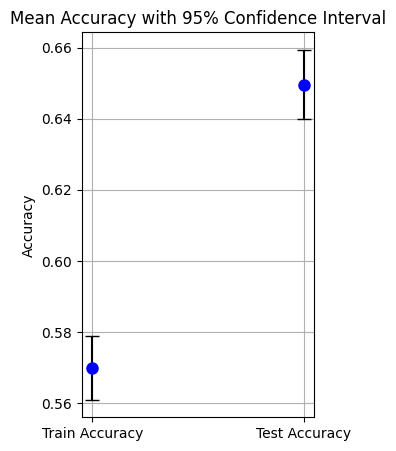

In [39]:
means = [mean_train_acc, mean_test_acc]
lower_errors = [mean_train_acc - ci_lower_train, mean_test_acc - ci_lower_test]
upper_errors = [ci_upper_train - mean_train_acc, ci_upper_test - mean_test_acc]

# Make the error symmetric
error = np.array([lower_errors, upper_errors])

x = np.arange(len(means))  # 0 for train, 1 for test

plt.figure(figsize=(3, 5))
plt.errorbar(x, means, yerr=error, fmt='o', capsize=5, markersize=8, color='blue', ecolor='black', linestyle='none')
plt.xticks(x, ['Train Accuracy', 'Test Accuracy'])
plt.ylabel('Accuracy')
plt.title('Mean Accuracy with 95% Confidence Interval')
plt.grid(True)
plt.show()

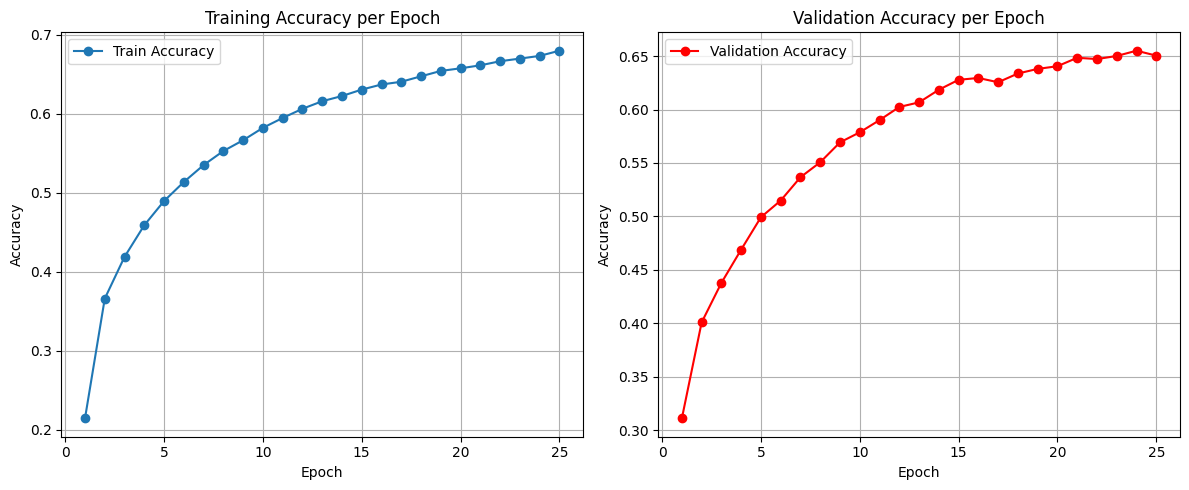

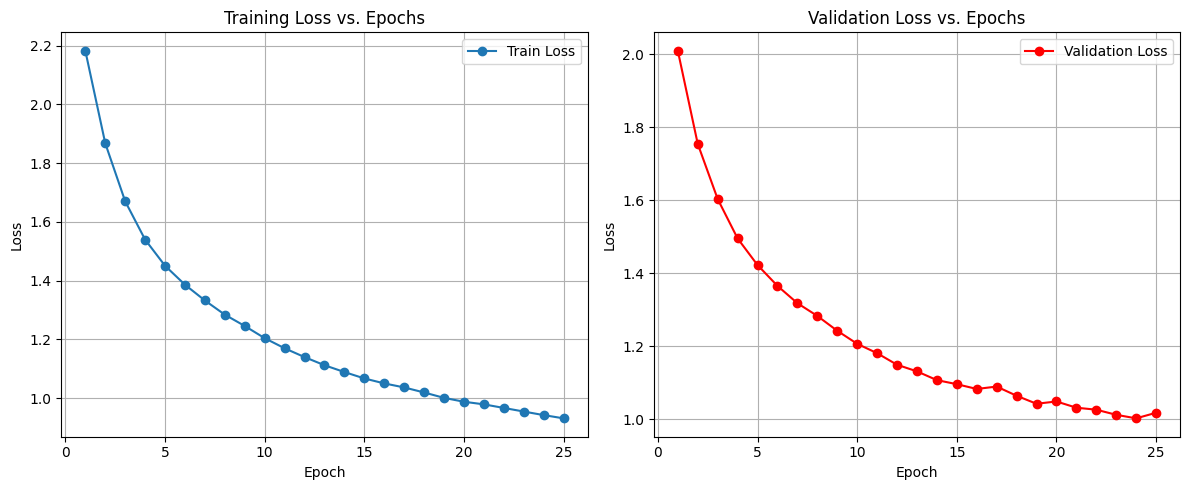

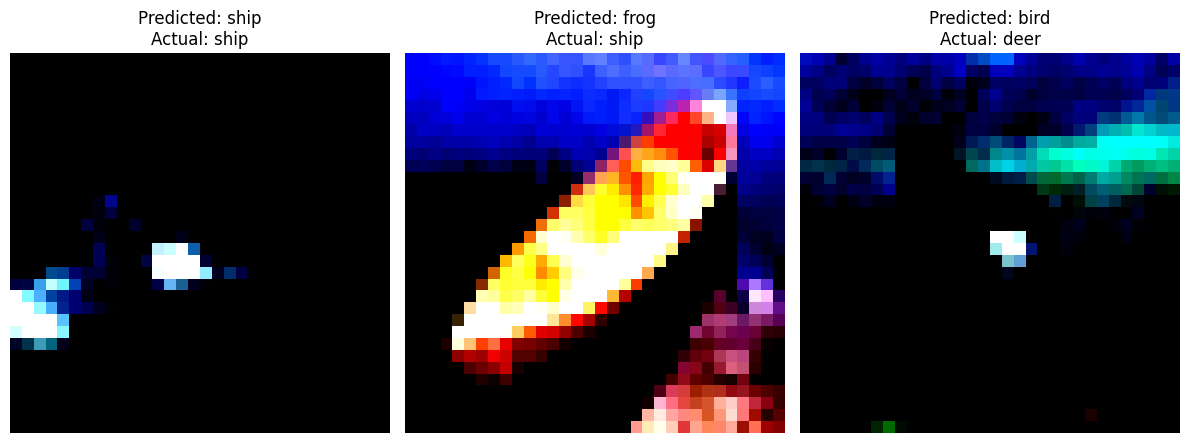

Accuracy: 0.6434
F1 Score (weighted): 0.6411302439569324

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.69      0.66      1000
           1       0.77      0.79      0.78      1000
           2       0.47      0.55      0.51      1000
           3       0.48      0.47      0.48      1000
           4       0.64      0.42      0.51      1000
           5       0.57      0.55      0.56      1000
           6       0.72      0.76      0.74      1000
           7       0.74      0.67      0.70      1000
           8       0.68      0.80      0.73      1000
           9       0.75      0.73      0.74      1000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
weighted avg       0.65      0.64      0.64     10000



In [40]:
epochs_list = np.arange(1, len(train_acc) + 1)

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_acc, label='Train Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, valid_acc, label='Validation Accuracy', marker='o',color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, valid_losses, label='Validation Loss', marker='o', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

num_img_to_show = min(3, len(all_test_images))
fig = plt.figure(figsize=(12, 6))
for i in range(num_img_to_show):
    random_index = random.randint(0, len(all_test_images) - 1)
    ax = fig.add_subplot(1, num_img_to_show, i + 1)
    ax.axis('off')
    img = all_test_images[random_index].transpose((1, 2, 0))
    ax.imshow(img)
    ax.set_title(f'Predicted: {class_names[all_preds[random_index]]}\nActual: {class_names[all_labels[random_index]]}')
plt.tight_layout()
plt.show()

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("F1 Score (weighted):", f1_score(all_labels, all_preds, average='weighted'))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

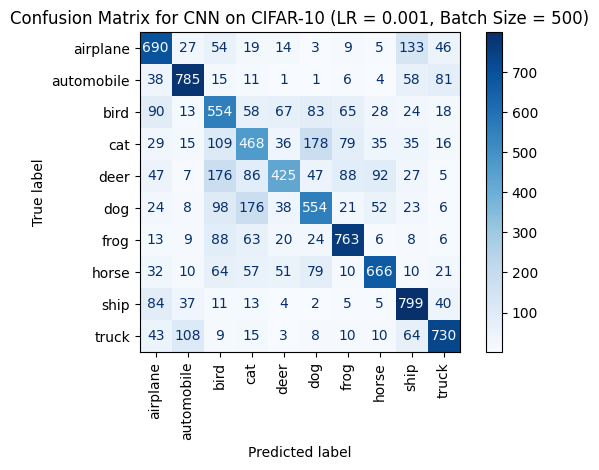

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix for CNN on CIFAR-10 (LR = 0.001, Batch Size = 500)')
plt.tight_layout()
plt.show()